# Implicit learning of visual ensembles during visual search in children with ASD

**Researchers: Sander Van de Cruys, Lisa Lemmens, Andrey Chetverikov, Laurie-Anne Sapey-Triomphe, Ilse Noens, Johan Wagemans**
___


See task,  procedure and participant description in the [Manuscript draft](https://docs.google.com/document/d/1N63YVUppCZ2AC4IBXmuS6sWog9-t3Xsq8YmCbZ6DMPo/edit?usp=sharing)

TODO:



Notes:

* Warning: This is a working document, and may contain coding or reasoning errors...
* Errorbars are 95% ci's (for the python plots)


<img src="img/task.jpg" style="height:800px">


# Importing the required python libraries:

In [1]:
import glob, os #file utilities
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # roughly ~base R plotting functionality
import pandas as pd #roughly ~base R & tidyr functionality 
import seaborn as sns #roughly ~ggplot2 functionality
import statsmodels.api as sm
from statsmodels import stats
import statsmodels.formula.api as smf
from bambi import Model
import pymc3 as pm
import bambi
import warnings
import ptitprince as pt # python version of rain cloud plots
import pingouin as pg # statistical tests
import rpy2
from sklearn import preprocessing #for scale function
warnings.filterwarnings('ignore')

#to make the plots appear inline, and saved in notebook:
%matplotlib inline
sns.set_context("paper") # seaborn function to make plots according to purpose (talk, paper, poster, notebook)

# We'll show people what versions we use
import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)
import IPython
print(IPython.sys_info())
#!pip freeze | grep -E 'seaborn|matplotlib|pandas|statsmodels|pingouin'

%load_ext watermark
%watermark -v -m -p scipy,numpy,rpy2,sklearn,seaborn,statsmodels,pandas,matplotlib,pingouin -g

Ran on 2019-10-04T18:12:52.199526
{'commit_hash': 'c233c25ab',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/home/sander/.local/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.8.0',
 'os_name': 'posix',
 'platform': 'Linux-5.0.0-29-generic-x86_64-with-Ubuntu-19.04-disco',
 'sys_executable': '/usr/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.7.3 (default, Aug 20 2019, 17:04:43) \n[GCC 8.3.0]'}
CPython 3.7.3
IPython 7.8.0

scipy 1.3.1
numpy 1.17.2
rpy2 3.1.0
sklearn 0.21.3
seaborn 0.9.0
statsmodels 0.10.1
pandas 0.25.1
matplotlib 3.1.1
pingouin 0.2.9

compiler   : GCC 8.3.0
system     : Linux
release    : 5.0.0-29-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 4fdcbd7a7059a7cd82ba64294c7bd466938a96d6


# Import R interface, libraries

In [2]:
import rpy2.rinterface
%reload_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [3]:
%%R 

library(lme4)
library(segmented)
library(tidyverse)
library(ggplot2)
library(BayesFactor)
library(lmerTest)
library(ggpubr)
library(cowplot)

R[write to console]: Loading required package: Matrix

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()

R[write to console]: Loading required package: coda

R[write to console]: ************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme

# Import and inspect data

In [4]:
# importing data
df = pd.DataFrame()    
all_files = glob.glob(os.path.join('Data','Exp', "*.csv")) # get list of individual data files
all_files.sort()

import re 

for file in all_files:
    idcode = re.findall('\d+', file)[0]
    dfnew = pd.read_csv(file).assign(subjectId=int(idcode)) #read file and add column for id
    df = pd.concat([df, dfnew], ignore_index=True)

df['group'] = np.where(df['subjectId']<100, 'ASD', 'TD')
df["subjectId"] = df["subjectId"].astype('str')

# Select informative variables and add new variables

In [5]:
vars = ['expName','subjectId','group','session','blockN', 'totBlockN', 'trialN','targetOri','targetPos', 'targetRow','distrMean','dtype','dsd','targetDist','prevDistrMean','streak_length_prime', 'seq_type','answer','rt','correct','d_ori_1', 'd_ori_2','d_ori_3', 'd_ori_4', 'd_ori_5', 'd_ori_6', 'd_ori_7', 'd_ori_8', 'd_ori_9', 'd_ori_10', 'd_ori_11', 'd_ori_12', 'd_ori_13', 'd_ori_14', 'd_ori_15', 'd_ori_16', 'd_ori_17', 'd_ori_18', 'd_ori_19', 'd_ori_20', 'd_ori_21', 'd_ori_22', 'd_ori_23', 'd_ori_24', 'd_ori_25', 'd_ori_26', 'd_ori_27', 'd_ori_28', 'd_ori_29', 'd_ori_30', 'd_ori_31', 'd_ori_32', 'd_ori_33', 'd_ori_34', 'd_ori_35']

df= df[vars]

#function to calculate difference between two angles (from Andrey)
def angle_dist_180(a,b):
    c = a - b
    return (c+90)%180 - 90


df = df.assign(rt=df.rt*1000, 
        previous_correct = df.correct.shift(1), #Previous trial correct
        previous_target = df.targetOri.shift(1), #Previous target orientation
        log_rt = np.log(df.rt), 
        rt_inv= 1/df.rt,       
        ctpd= angle_dist_180(df.targetOri,df.prevDistrMean), #CT-PD: difference between current target ori and previous distractor ori mean. 
        cdpd = angle_dist_180(df.distrMean,df.prevDistrMean), #CD-PD: difference between current distractor ori mean and previous distractor ori    mean.
        targetDist_ang = angle_dist_180(df.distrMean,df.targetOri))

df['cdpt'] = angle_dist_180(df.distrMean,df.previous_target) #CD-PT: difference between current distractor ori mean and previous target ori.
df['ctpt'] = angle_dist_180(df.targetOri,df.previous_target) #CT-PT: difference between current target ori mean and previous target ori.  
df['abs_ctpd'] = abs(df.ctpd) #absolute value of CT-PD
df['abs_cdpt'] = abs(df.cdpt) #absolute value of CD-PT
df['abs_ctpt'] = abs(df.ctpt) # absolute value of CT-PT
df['abs_cdpd'] = abs(df.cdpd)
df['dsd_a'] = df.filter(regex=("d_ori.*")).std(axis=1) #compute actual distractor ori sd

df['distrMean'] = np.where(df.distrMean > 90, df.distrMean - 180, df.distrMean) #Convert them to orientations between -90° & + 90°
df.distrMean = np.where(df.distrMean < -90, df.distrMean + 180, df.distrMean)
df.distrMean = np.where(df.distrMean > 90, df.distrMean - 180, df.distrMean)
df.distrMean = np.where(df.distrMean> 90, df.distrMean - 180, df.distrMean)
df['targetOri'] = np.where(df.targetOri > 90, df.targetOri - 180, df.targetOri)
df.targetOri = np.where(df.targetOri < -90, df.targetOri + 180, df.targetOri)
df.targetOri = np.where(df.targetOri > 90, df.targetOri - 180, df.targetOri)
df.targetOri = np.where(df.targetOri > 90, df.targetOri - 180, df.targetOri)

df['ctpd_2'] = df.ctpd**2 #Quadratic predictors
df['ctpt_2'] = df.ctpt**2
df['targetDist_ang_2'] = df.targetDist_ang**2


scaled= [('rt_z', 'rt'),('ctpd_z','ctpd'), ('cdpt_z', 'cdpt'), ('ctpt_z', 'ctpt'),('cdpd_z','cdpd'), ('abs_ctpd_z', 'abs_ctpd'),('abs_ctpt_z','abs_ctpt'), ('abs_cdpd_z','abs_cdpd'), ('ctpd_z2', 'ctpd_2'), ('ctpt_z2', 'ctpt_2'),('targetDist_ang_z_2', 'targetDist_ang_2')]

for var in scaled: 

    df[var[0]] = df.groupby(['subjectId'])[var[1]].transform(preprocessing.scale)

# adding variables to indicate transition between sequence types (unequal len of sequences), prime or probe 
df['block_len'] = df.groupby(['subjectId','totBlockN'])['rt'].transform('count')
df['is_last'] = np.where(df.trialN==5,1,0)       
df.is_last = np.where((df.dsd == 10) & (df.block_len == 6) & (df.trialN==5),1,df.is_last)
df.is_last = np.where((df.dsd == 10) & (df.block_len == 5) & (df.trialN==4),1,df.is_last)
df.is_last = np.where((df.dsd == 5) & (df.block_len == 1) & (df.trialN==0),1,df.is_last) 
df.is_last = np.where((df.dsd == 5) & (df.block_len == 2) & (df.trialN==1),1,df.is_last) 

df['transprime'] = np.where((df.dsd == 10) & (df.is_last ==1),0,np.NaN)
df.transprime = np.where((df.dsd == 5) & (df.trialN ==0),1,df.transprime)
df['transprobe'] = np.where((df.dsd == 5) & (df.is_last ==1),0,np.NaN)
df.transprobe = np.where((df.dsd == 10) & (df.trialN ==0),1,df.transprobe)

# quantized version of distance between target ori and dsd mean
df['tDist'] = pd.qcut(df.targetDist_ang_z_2, 10, range(1,11))
df['tDist'] = df.tDist.astype('int32')

df['in_range'] = np.where(df.abs_ctpd > 30, "out", "in")


In [359]:
df.iloc[:30,:20]

,expName,subjectId,group,session,blockN,totBlockN,trialN,targetOri,targetPos,targetRow,distrMean,dtype,dsd,targetDist,prevDistrMean,streak_length_prime,seq_type,answer,rt,correct
0,orientation_search,1,ASD,1,0,0,0,3.6,31,1,84.599572,norm,10,99,NaN,6,prime,up,1201.695831,0
1,orientation_search,1,ASD,1,0,0,1,-35.4,21,3,84.599572,norm,10,60,NaN,6,prime,up,1810.640007,1
2,orientation_search,1,ASD,1,0,0,2,16.6,25,1,84.599572,norm,10,112,NaN,6,prime,up,2246.566126,0
3,orientation_search,1,ASD,1,0,0,3,-16.4,30,0,84.599572,norm,10,79,NaN,6,prime,down,2438.014591,1
4,orientation_search,1,ASD,1,0,0,4,18.6,20,2,84.599572,norm,10,114,NaN,6,prime,down,4845.820144,1
5,orientation_search,1,ASD,1,0,0,5,4.6,19,1,84.599572,norm,10,100,NaN,6,prime,down,4405.121540,1
6,orientation_search,1,ASD,1,1,1,0,-48.1,34,4,30.910955,norm,5,79,84.599572,6,probe,up,1373.607321,1
7,orientation_search,1,ASD,1,1,1,1,-48.1,13,1,19.910955,norm,5,68,84.599572,6,probe,down,1449.623583,1
8,orientation_search,1,ASD,1,2,2,0,55.6,16,4,-37.442700,norm,10,93,84.599572,6,prime,up,2613.396101,1
9,orientation_search,1,ASD,1,2,2,1,38.6,32,2,-37.442700,norm,10,76,84.599572,6,prime,down,1736.839293,1


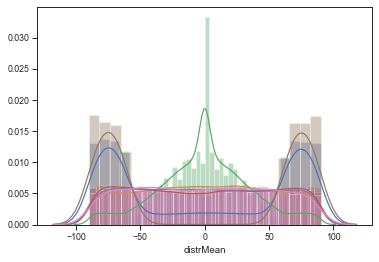

In [263]:
sns.distplot(df.cdpt.dropna()) 
sns.distplot(df.ctpd.dropna())
sns.distplot(df.ctpt.dropna())
sns.distplot(df.cdpd.dropna())
sns.distplot(df.targetOri.dropna())
sns.distplot(df.targetDist_ang.dropna())
sns.distplot(df[(df.correct ==1) & (df.dsd == 5)].distrMean.dropna())


In [683]:
# count missing values
#df.isnull().sum().head(60)

# Inspect data characteristics

In [6]:
print('Variables:\n', df.columns)
print('variables:\n', df.dtypes)
print('nb of participants:', len(df['subjectId'].unique()))
df.groupby('group')['subjectId'].nunique()

Variables:
 Index(['expName', 'subjectId', 'group', 'session', 'blockN', 'totBlockN',
       'trialN', 'targetOri', 'targetPos', 'targetRow', 'distrMean', 'dtype',
       'dsd', 'targetDist', 'prevDistrMean', 'streak_length_prime', 'seq_type',
       'answer', 'rt', 'correct', 'd_ori_1', 'd_ori_2', 'd_ori_3', 'd_ori_4',
       'd_ori_5', 'd_ori_6', 'd_ori_7', 'd_ori_8', 'd_ori_9', 'd_ori_10',
       'd_ori_11', 'd_ori_12', 'd_ori_13', 'd_ori_14', 'd_ori_15', 'd_ori_16',
       'd_ori_17', 'd_ori_18', 'd_ori_19', 'd_ori_20', 'd_ori_21', 'd_ori_22',
       'd_ori_23', 'd_ori_24', 'd_ori_25', 'd_ori_26', 'd_ori_27', 'd_ori_28',
       'd_ori_29', 'd_ori_30', 'd_ori_31', 'd_ori_32', 'd_ori_33', 'd_ori_34',
       'd_ori_35', 'previous_correct', 'previous_target', 'log_rt', 'rt_inv',
       'ctpd', 'cdpd', 'targetDist_ang', 'cdpt', 'ctpt', 'abs_ctpd',
       'abs_cdpt', 'abs_ctpt', 'abs_cdpd', 'dsd_a', 'ctpd_2', 'ctpt_2',
       'targetDist_ang_2', 'rt_z', 'ctpd_z', 'cdpt_z', 'ctpt_z', 'cdp

group
ASD    24
TD     25
Name: subjectId, dtype: int64

## Explanation of variables:
    
- d_ori_xx = orientation of line number xx (goes from 0 to 35 where 0 is top left corner of a stimuli matrix and 35 is a bottom right corner; the stimuli matrix is filled by column, so item 0 has coordinates of [-8., -8.], item 1 has coordinates of [-8., -4.8.], item 5 - array([-8.,  8.]), and item 6 -  [-4.8, -8. ])
- set_size = number of lines in one set (always 36 here)
- stim_pos_x_30 = position of line number xx
- test_set_size = number of lines in test set (always 36)
- targetCol = column in which target is located
- dsd_test = distractors distribution SD of the test trials (always 5 here)
- seq_type = is it a prime trial or a test trial
- dsd = distractors distribution SD
- blockRepN = repetition of the different combinations of conditions (5 times here)
- targetDist - distance (in orientation) between targetOri and distrMean
- dtype_test = type of test distribution (always normal)
- prime_set_size = set size prime trials (always 36)
- correctResponse = what the correct response is
- dtype = distribution type (always normal)
- distrMean = mean of distractors orientation
- targetRow = row in which target is located
- dsd_prime = distractors distribution SD of prime trials
- streak_length_prime = number of trials in prime streaks (5 or 6)
- targetOri = target orientation 
- targetPos = position of target
- trialN = trial number within test or prime streak
- dtype_prime = distribution type in prime trials
- totBlockN = total number of streaks/blocks
- blockN = number of blocks per repetition of all conditions
- prevDistrCTPD = previous difference between target orientation and previous distractor mean
- prevDistrMean = previous distribution mean
- prevDistrType = previous distribution type
- answer = reponse (down or up)
- rt = reaction time
- correct = accuracy 
- trialScore
- session
- participant

# Remove outliers

(-500, 5000)

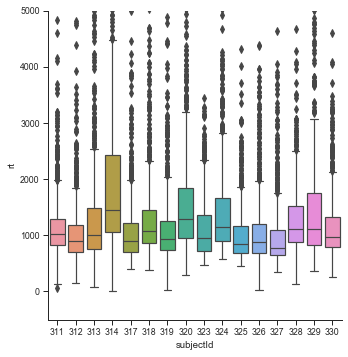

In [335]:
ax= sns.catplot(x="subjectId", y="rt", kind="box", data=df[pd.to_numeric(df.subjectId)>310]);

plt.ylim([-500, 5000])

2798.1974424418195

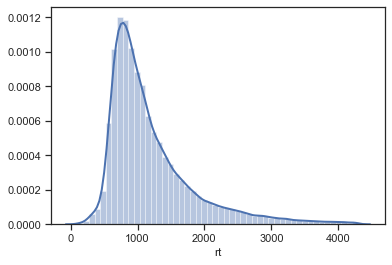

In [663]:
sns.distplot(df.rt[(df.rt<6500) & (df.rt>100)],bins=50) 

df.rt.mean()+(df.rt.std()*5)

#df.rt.quantile(.01)
df.rt.mean()+(df.rt.std()*2.5)
#df.groupby(['subjectId']).agg({'rt': [lambda x: x.mean()+(x.std()*3), lambda x: x.quantile(.99)]})


In [11]:
countsBefore = df.groupby(['group']).rt.count()

df = df[df.rt<(df.rt.mean()+(df.rt.std()*3))] # remove very high rts
df = df[df.rt>100] # remove implausibly low rts
df = df[df.subjectId!='314'] # participant with a higher range/mean

def filter_func(x):
    return x['rt'] < x['rt'].mean()+(3*x['rt'].std())

# remove extreme outliers per participant
df = df[df.groupby('subjectId').apply(filter_func).reset_index().rt.values]

countsAfter = df.groupby(['group']).rt.count()

counts= countsBefore.reset_index()

counts['after']= countsAfter.reset_index().rt
counts['nlost']= counts.rt-counts.after
counts['perc_lost']= (counts.nlost/counts.rt)*100

counts

,group,rt,after,nlost,perc_lost
0,ASD,21869,21209,660,3.017971
1,TD,22412,21051,1361,6.072640


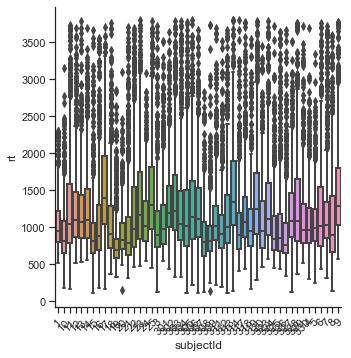

In [491]:
g = sns.catplot(x="subjectId", y="rt", kind="box", data=df[df.correct==1]);
g.set_xticklabels(rotation=45)


# Add descriptive data

In [12]:
# add demographics
demo_asd = pd.read_csv("Data/deelnemers_ASD.csv")
demo_td = pd.read_csv("Data/CONTROLEdeelnemers.csv")

dfdescr = pd.concat([demo_asd, demo_td], ignore_index=True)

vars= ["SubjectId","leeftijd", "Geslacht", "VIQ", "PIQ","SRS_TOTAAL","SRS_SB", "SRS_SCOG", "SRS_SCOM", "SRS_SM", "SRS_AP", "IU","CBCL","SP", "ADOS","ADOS_SA","ADOS_BRG"]

dfdescr = dfdescr[vars]


dfdescr['TIQ'] = (dfdescr.PIQ + dfdescr.VIQ)/2

dfdescr.SubjectId[dfdescr.SubjectId=='016_goed']='016'
dfdescr = dfdescr[dfdescr.SubjectId.notna()]

dfdescr.SubjectId= dfdescr.SubjectId.astype(int)
#dfdescr.SRS_TOTAAL = pd.to_numeric(dfdescr.SRS_TOTAAL)
#dfdescr.SP = pd.to_numeric(dfdescr.SP)
#dfdescr.SP = pd.to_numeric(dfdescr.SP)

for i in dfdescr.columns:
    if i=='SubjectId':
        continue
    dfdescr[i] = pd.to_numeric(dfdescr[i], errors='coerce')

dfdescr.SubjectId= dfdescr.SubjectId.astype(str)


In [43]:
dfdescr.head()

,SubjectId,leeftijd,Geslacht,VIQ,PIQ,SRS_TOTAAL,SRS_SB,SRS_SCOG,SRS_SCOM,SRS_SM,SRS_AP,IU,CBCL,SP,ADOS,ADOS_SA,ADOS_BRG,TIQ
0,1,10.22,0.0,92.0,97.0,91,67.0,89.0,91.0,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5
1,2,13.66,0.0,62.0,91.0,95,67.0,102.0,87.0,78.0,95.0,41.0,70.0,142.0,3.0,3.0,0.0,76.5
2,3,11.40,0.0,122.0,103.0,86,63.0,82.0,87.0,67.0,89.0,NaN,NaN,162.0,14.0,NaN,NaN,112.5
3,4,10.72,0.0,127.0,120.0,77,73.0,71.0,65.0,65.0,92.0,47.0,66.0,NaN,9.0,7.0,2.0,123.5
4,5,11.93,0.0,114.0,132.0,96,83.0,94.0,85.0,83.0,92.0,53.0,57.0,180.0,5.0,5.0,0.0,123.0


In [13]:
df= pd.merge(df, dfdescr, how='left', left_on='subjectId', right_on='SubjectId')
#add variable split SRS
df['SRSsplit'] = pd.qcut(df.SRS_TOTAAL, 3, labels=['low','mid','high'])
df.head()

,expName,subjectId,group,session,blockN,totBlockN,trialN,targetOri,targetPos,targetRow,...,SRS_SM,SRS_AP,IU,CBCL,SP,ADOS,ADOS_SA,ADOS_BRG,TIQ,SRSsplit
0,orientation_search,1,ASD,1,0,0,0,3.6,31,1,...,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high
1,orientation_search,1,ASD,1,0,0,1,-35.4,21,3,...,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high
2,orientation_search,1,ASD,1,0,0,2,16.6,25,1,...,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high
3,orientation_search,1,ASD,1,0,0,3,-16.4,30,0,...,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high
4,orientation_search,1,ASD,1,1,1,0,-48.1,34,4,...,73.0,89.0,39.0,60.0,NaN,5.0,5.0,0.0,94.5,high


In [9]:
df.to_csv('preproc_df.csv')

# Do matching on IQ, gender and age

### Age

leeftijd                                                                
         count       mean       std    min    25%    50%        75%        max
group                                                                         
ASD       23.0  12.049809  1.329276  10.22  10.91  11.84  13.165822  14.986301
TD        25.0  11.850679  1.500949  10.01  10.90  11.52  12.643836  14.947945

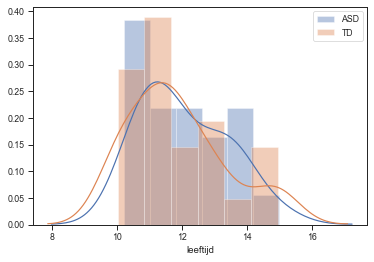

In [104]:
dfm = df.groupby(['group', 'subjectId']).leeftijd.mean().reset_index()

sns.distplot(dfm[dfm.group=='ASD'].leeftijd.dropna(), label="ASD", bins=6)
sns.distplot(dfm[dfm.group=='TD'].leeftijd.dropna(), label="TD", bins=6)
plt.legend();

dfm.groupby(['group']).describe()

In [105]:
pg.ttest(dfm[dfm.group=="ASD"].leeftijd, dfm[dfm.group=="TD"].leeftijd, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.49,45.94,greater,0.31,"[-0.49, inf]",0.14,0.634,0.12


### IQ

TIQ                                                         
      count        mean        std   min    25%    50%    75%    max
group                                                               
ASD    23.0  105.043478  13.275844  82.5   96.5  102.5  115.5  123.5
TD     25.0  105.860000   9.395832  84.5  103.0  107.0  108.5  131.0

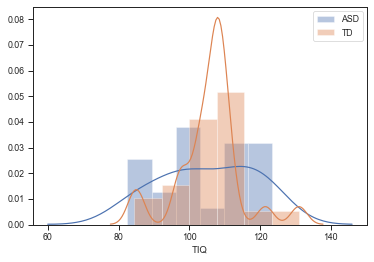

In [106]:
dfm = df.groupby(['group', 'subjectId']).TIQ.mean().reset_index()

sns.distplot(dfm[dfm.group=='ASD'].TIQ.dropna(), label="ASD", bins=6)
sns.distplot(dfm[dfm.group=='TD'].TIQ.dropna(), label="TD", bins=6)
plt.legend();

dfm.groupby(['group']).describe()

In [107]:
pg.ttest(dfm[dfm.group=="ASD"].TIQ, dfm[dfm.group=="TD"].TIQ, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.24,39.3,less,0.4,"[-inf, 4.82]",0.07,0.589,0.08


In [110]:
dfm = df.groupby(['group', 'subjectId']).VIQ.mean().reset_index()
pg.ttest(dfm[dfm.group=="ASD"].VIQ, dfm[dfm.group=="TD"].VIQ, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.15,36.52,less,0.44,"[-inf, 6.46]",0.04,0.58,0.07


In [111]:
dfm = df.groupby(['group', 'subjectId']).PIQ.mean().reset_index()
pg.ttest(dfm[dfm.group=="ASD"].PIQ, dfm[dfm.group=="TD"].PIQ, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.22,42.25,less,0.41,"[-inf, 6.75]",0.06,0.586,0.08


### CBCL

CBCL                                                   
      count       mean       std   min   25%   50%   75%   max
group                                                         
ASD    19.0  57.578947  7.618076  50.0  51.0  56.0  61.0  77.0
TD     21.0  54.666667  5.876507  50.0  50.0  51.0  57.0  66.0

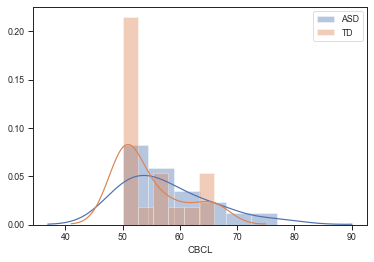

In [114]:
dfm = df.groupby(['group', 'subjectId']).CBCL.mean().reset_index()
sns.distplot(dfm[dfm.group=='ASD'].CBCL.dropna(), label="ASD", bins=6)
sns.distplot(dfm[dfm.group=='TD'].CBCL.dropna(), label="TD", bins=6)
plt.legend();

dfm.groupby(['group']).describe()

In [115]:
pg.ttest(dfm[dfm.group=="ASD"].CBCL, dfm[dfm.group=="TD"].CBCL, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.34,33.79,greater,0.09,"[-0.75, inf]",0.43,1.258,0.38


### Gender (number of females)

In [154]:
dfm = df.groupby(['group', 'subjectId']).Geslacht.mean().reset_index()
dfc = dfm.groupby(['group']).Geslacht.sum().reset_index()
dfc

,group,Geslacht
0,ASD,8.0
1,TD,12.0


In [175]:
count = dfc.Geslacht.values.tolist()
nobs= dfm.groupby(['group']).Geslacht.count().reset_index().Geslacht.values.tolist()
stats.proportion.proportions_chisquare(count,nobs, value=None)[:2]

# Explore questionnaire data


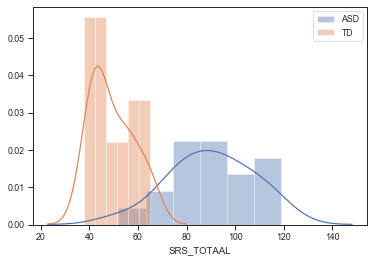

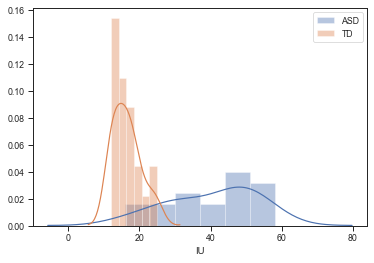

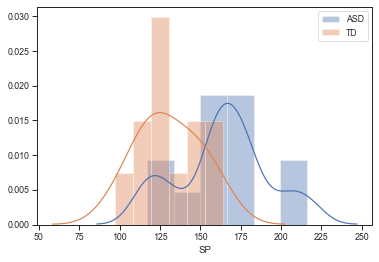

In [188]:
dfsumQ= df.groupby(['subjectId', 'group']).agg({'SRS_TOTAAL':'mean', 'SP': 'mean', 'IU': 'mean'}).reset_index()

for i in ['SRS_TOTAAL', 'IU', 'SP']:
    plt.figure()
    g = sns.distplot(dfsumQ[dfsumQ.group=='ASD'][i].dropna(), label="ASD", bins=6)
    sns.distplot(dfsumQ[dfsumQ.group=='TD'][i].dropna(), label="TD", bins=6)
    plt.legend()

"The SRS has high internal consistency (Cronbach’s alpha = 0.76), and has good discriminant validity (Constantino 2002). Sensitivity and specificity are 0.85 and 0.75, respectively, when the SRS total score of 75 is used as the cutoff (Bölte et al. 2011; Constantino 2002)." (Moody et al 2017)

In [37]:
df.SRS_TOTAAL.quantile([.33,.67])

0.33    52.0
0.67    80.0
Name: SRS_TOTAAL, dtype: float64

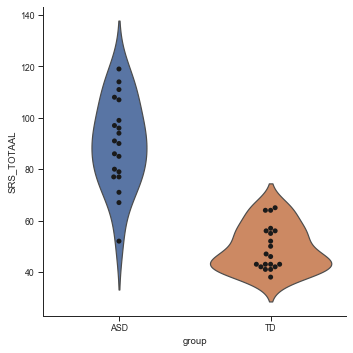

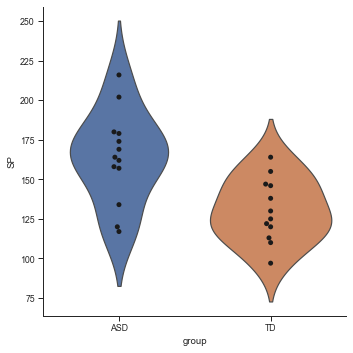

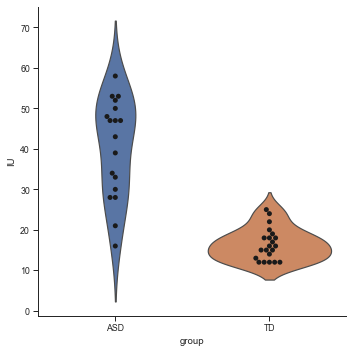

In [189]:
g = sns.catplot(x="group", y="SRS_TOTAAL", kind="violin", inner=None, data=dfsumQ);
sns.swarmplot(x="group", y="SRS_TOTAAL", color='k', size=5, data=dfsumQ, ax=g.ax);
g = sns.catplot(x="group", y="SP", kind="violin", inner=None, data=dfsumQ);
sns.swarmplot(x="group", y="SP", color='k', size=5, data=dfsumQ, ax=g.ax);
g = sns.catplot(x="group", y="IU", kind="violin", inner=None, data=dfsumQ);
sns.swarmplot(x="group", y="IU", color='k', size=5, data=dfsumQ, ax=g.ax);

Missing questionnaire data:

In [74]:
dfsumQ.SP.isna().sum(), dfsumQ.SRS_TOTAAL.isna().sum(), dfsumQ.IU.isna().sum()

(23, 8, 9)

In [190]:
pg.ttest(dfsumQ.query('group=="ASD"').SRS_TOTAAL, dfsumQ.query('group=="TD"').SRS_TOTAAL, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,9.46,38,greater,0.0,"[33.36, inf]",2.99,7.066e+08,1.0


In [191]:
pg.ttest(dfsumQ.query('group=="ASD"').SP, dfsumQ.query('group=="TD"').SP, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.4,21.41,greater,0.0,"[16.54, inf]",1.34,30.182,0.95


In [192]:
pg.ttest(dfsumQ.query('group=="ASD"').IU, dfsumQ.query('group=="TD"').IU, paired=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,7.98,20.04,greater,0.0,"[18.78, inf]",2.73,9.869e+06,1.0


# General visual search performance

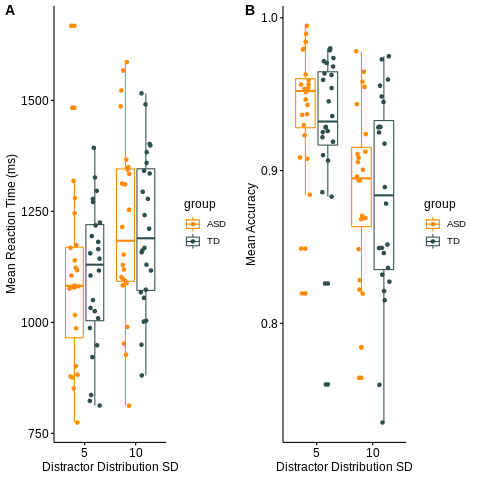

In [19]:
%%R 

df_filter <- suppressMessages(read_csv('preproc_df.csv'))

RTmeans_condition<- df_filter %>%
  filter(correct==1) %>% #only for correct responses
  group_by(subjectId,dtype,dsd,group) %>%
  summarise(mean_rt=mean(rt),sd_rt=sd(rt), mean_log_rt = mean(log_rt), sd_log_rt=sd(log_rt))

accmeans_condition<- df_filter %>%
  group_by(group,subjectId,dtype,dsd) %>%
  summarise(mean_acc=mean(correct),sd_acc=sd(correct))

means_condition <- RTmeans_condition%>%right_join(accmeans_condition, by=c("group","subjectId","dtype","dsd")) #RT and accuracy together

#summary table per group per condition
means_condition %>%
  group_by(group,dsd) %>%
  summarise(count = n(),acc=mean(mean_acc), sd_acc = sd(mean_acc), rt = mean(mean_rt), sd_rt=sd(mean_rt))

#Summary table per condition
means_condition %>%
  group_by(dsd) %>%
  summarise(count = n(),acc=mean(mean_acc), sd_acc = sd(mean_acc), rt = mean(mean_rt), sd_rt=sd(mean_rt))

#Plot RT data and acc data
plot_RT <- ggboxplot(means_condition, x = "dsd", y = "mean_rt", color = "group", add= "jitter", legend = "right", ylab="Mean Reaction Time (ms)", xlab = "Distractor Distribution SD" ) + scale_color_manual(values=c("darkorange", "darkslategrey"))+ scale_x_discrete( limits=c("5","10"))
#+ ggtitle("Mean Reaction Time per Group and per Condition") +theme(plot.title = element_text(hjust = 0.5))

plot_acc<- ggboxplot(means_condition, x = "dsd", y = "mean_acc", color = "group", add= "jitter", legend = "right", ylab="Mean Accuracy", xlab = "Distractor Distribution SD" )+ scale_color_manual(values=c("darkorange", "darkslategrey")) + scale_x_discrete( limits=c("5","10"))
# ggtitle("Mean Accuracy per Group and per Condition")+theme(plot.title = element_text(hjust = 0.5))
  
#Together in one figure with labels
plot_grid(plot_RT, plot_acc, labels = "AUTO")

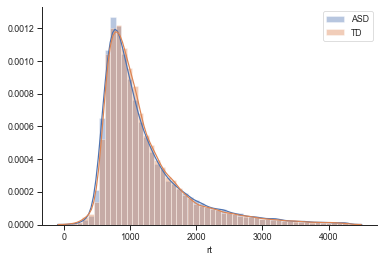

In [193]:
fig, ax = plt.subplots()
groups = ['ASD', 'TD']

for group in groups:
    condition_data = df[(df['group'] == group) & (df['correct']==1)]['rt']
    sns.distplot(condition_data, kde=True, label=group)

plt.legend();
sns.despine()


In [20]:
dfsum = df.groupby(['group', 'subjectId', 'dsd']).mean().reset_index()
dfsumrt = df.query('(correct==1)').groupby(['group', 'subjectId', 'dsd']).mean().reset_index()
# compute inverse efficiency score (ies) to account for speed-accuracy trade off
dfsum['ies']= dfsum.rt/dfsum.correct


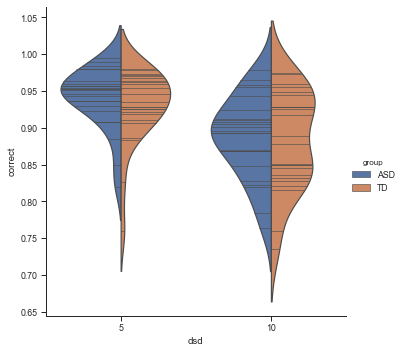

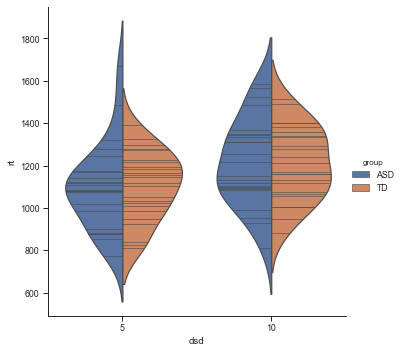

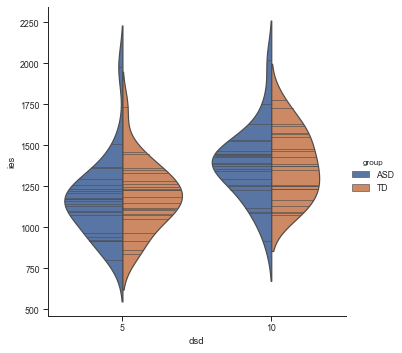

In [239]:
sns.catplot(x="dsd", y="correct", hue="group",
            kind="violin", split=True,inner="stick", data=dfsum);

sns.catplot(x="dsd", y="rt", hue="group",
            kind="violin", split=True,inner="stick", data=dfsumrt);

sns.catplot(x="dsd", y="ies", hue="group",
            kind="violin", split=True,inner="stick", data=dfsum);


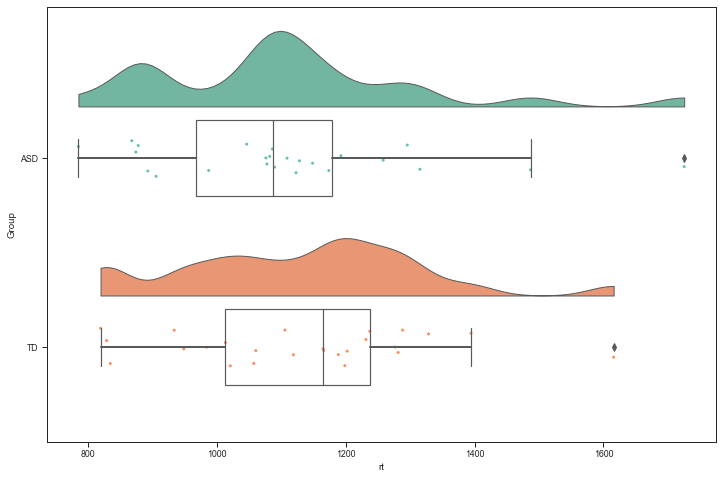

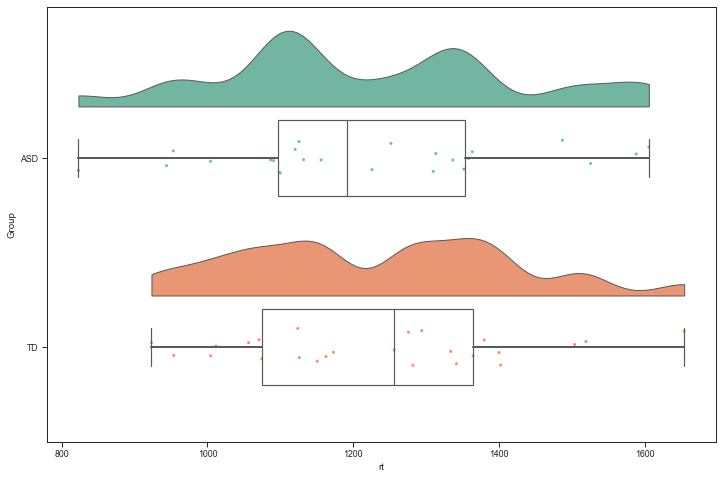

In [148]:
ax = pt.RainCloud(x = 'Group', y = 'rt', 
                  data = dfsumrt[dfsumrt.dsd==5], 
                  width_viol = .8,
                  width_box = .4,
                  figsize = (12, 8), orient = 'h',
                  move = .0)
ax = pt.RainCloud(x = 'Group', y = 'rt', 
                  data = dfsumrt[dfsumrt.dsd==10], 
                  width_viol = .8,
                  width_box = .4,
                  figsize = (12, 8), orient = 'h',
                  move = .0)

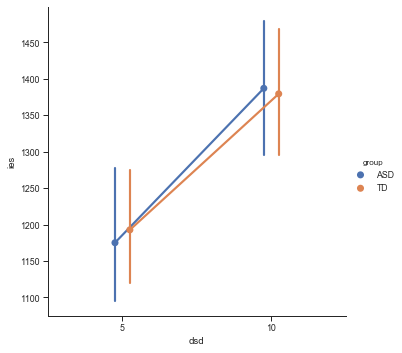

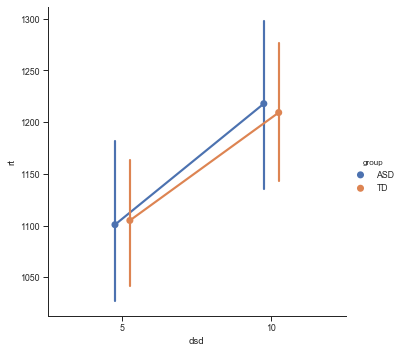

In [645]:
sns.catplot(x="dsd", y="ies", hue="group", kind="point",dodge=.1, data=dfsum);
sns.catplot(x="dsd", y="rt", hue="group", kind="point",dodge=.1, data=dfsumrt);

In [597]:
df[(df.correct==1)].groupby(['group', 'dsd']).rt.describe().reset_index()

,group,dsd,count,mean,std,min,25%,50%,75%,max
0,ASD,5,4324.0,1097.862441,517.730316,112.979705,768.411142,957.646043,1255.108504,4278.667133
1,ASD,10,14727.0,1218.209776,666.553786,129.115870,759.734630,998.371235,1451.866902,4293.175012
2,TD,5,4274.0,1118.237023,520.840247,114.831817,784.792458,974.332839,1300.412341,4288.041062
3,TD,10,14981.0,1220.548165,650.259980,112.862873,781.668431,1024.175010,1444.420409,4292.283575


## Post-error slowing?

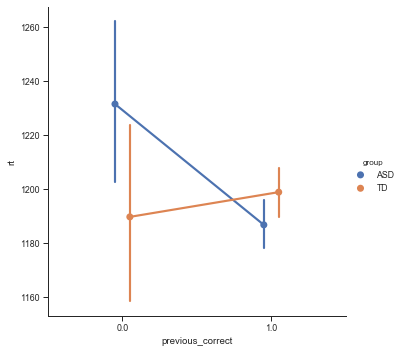

In [640]:
sns.catplot(x="previous_correct", y="rt", hue="group", kind="point",dodge=.1, data=df[df.correct==1]);

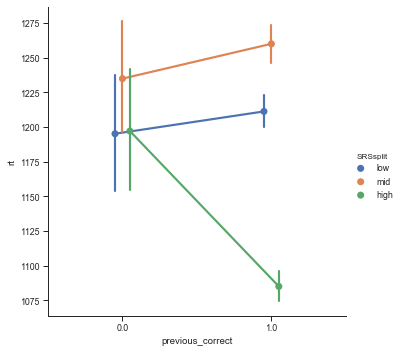

In [639]:
sns.catplot(x="previous_correct", y="rt", hue="SRSsplit", kind="point",dodge=.1, data=df[df.correct==1]);

In [62]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ tDist + dsd + C(previous_correct)*group", groups="subjectId",data=df[(df.correct==1)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                38306
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 470
                      Estimating Equations   Max. cluster size:                 859
Family:                           Gaussian   Mean cluster size:               781.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Mon, 16 Sep 2019   Scale:                      395870.302
Covariance type:                    robust   Time:                         17:34:30
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                     

## Distance between target ori and dsd mean

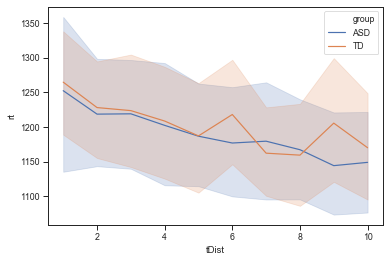

In [644]:
dfsumdist = df[(df.correct==1)].groupby(['group','subjectId', 'tDist']).rt.mean().reset_index()
sns.lineplot(x="tDist", y="rt", hue='group', data=dfsumdist);

In [14]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ dsd + tDist + group", groups="subjectId",data=df[(df.correct==1)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                38306
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 470
                      Estimating Equations   Max. cluster size:                 859
Family:                           Gaussian   Mean cluster size:               781.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Sat, 14 Sep 2019   Scale:                      395899.435
Covariance type:                    robust   Time:                         19:04:41
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1046.4884     43.904     23.836      0.000     960.438    1132.539
grou

In [496]:
md = smf.mixedlm("rt ~ dsd + tDist + group", df[(df.correct==1)], groups=df[(df.correct==1)]["subjectId"])
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: rt          
No. Observations:   38306   Method:             REML        
No. Groups:         49      Scale:              361759.3014 
Min. group size:    470     Likelihood:         -299581.9842
Max. group size:    859     Converged:          Yes         
Mean group size:    781.8                                   
------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975] 
------------------------------------------------------------
Intercept    1046.421   41.922 24.961 0.000 964.255 1128.587
group[T.TD]    11.964   55.180  0.217 0.828 -96.186  120.114
dsd            22.579    1.473 15.324 0.000  19.691   25.467
tDist         -10.199    1.070 -9.532 0.000 -12.296   -8.102
Group Var   36816.212   12.784                              



In [87]:
%%R

##linear mixed model with DV = RT, IV within = dsd
lmer_rt<-lmer(log_rt ~ dsd * group + (dsd|subjectId), REML=F,  data = df_filter[which(df_filter$correct==1), ])
print(summary(lmer_rt))

#general linear mixed model with DV = correct, IV within = dsd
glmer_acc<- glmer(correct ~ dsd * group +(dsd|subjectId), family = binomial, data = df_filter)
summary(glmer_acc)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log_rt ~ dsd * group + (dsd | subjectId)
   Data: df_filter[which(df_filter$correct == 1), ]

     AIC      BIC   logLik deviance df.resid 
 44698.2  44766.8 -22341.1  44682.2    39104 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5487 -0.7052 -0.1551  0.5904  3.7957 

Random effects:
 Groups    Name        Variance Std.Dev. Corr 
 subjectId (Intercept) 0.023522 0.15337       
           dsd10       0.003953 0.06287  -0.21
 Residual              0.182143 0.42678       
Number of obs: 39112, groups:  subjectId, 49

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    6.918607   0.031961 48.712472 216.471  < 2e-16 ***
dsd10          0.067559   0.014773 47.894035   4.573  3.4e-05 ***
groupTD        0.019260   0.044771 48.822841   0.430    0.669    
dsd10:groupTD -0.009482   0.020747 48.446797  -0.457    0.650    
---
S

## Interim conclusion: overall visual search performance

There seem to be no substantial differences. Lisa confirmed this with Bayesian tests for (log)rt: only a substantial effect for dsd (higher sd-> slower; more challenging. The literature on visual search in ASD find either faster search or no difference. But note that this concerns 'simpler' tasks that 

- Don't have the (manipulated) variability as we have here (dsd), distractors are more homogeneous in earlier studies, so simpler to disregard
- They often also don't have the odd-one-out character we have here, ie participants know what they have to search for.

So it is still interesting that ASD does not do worse here, they can deal with the variability (inferring the sameness in distractors to extract the deviant). Note that all the variability is relevant, in the sense that the more you can sample, the better the inference of what is same or different.

However, the data on the correlation with the social responsiveness scale (SRS; probing autism traits) casts a more nuanced picture. 

## Relation SRS, SP, IU and search performance

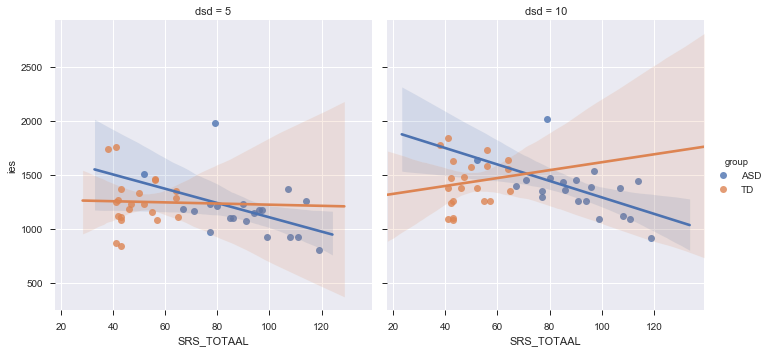

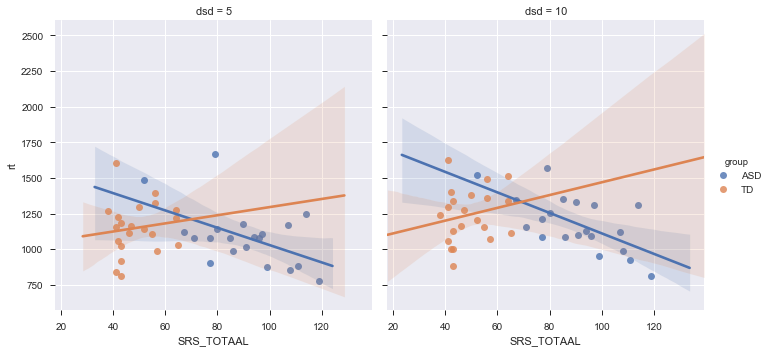

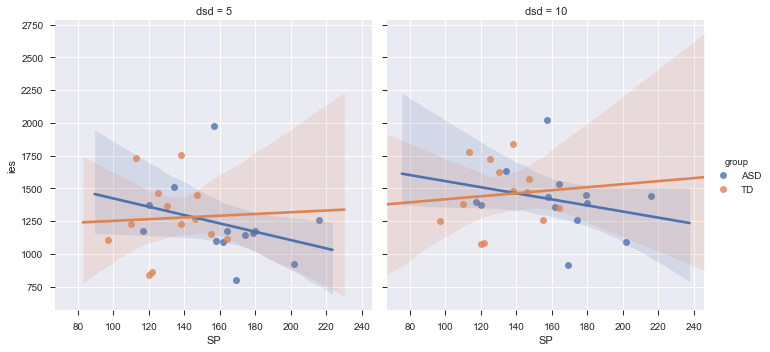

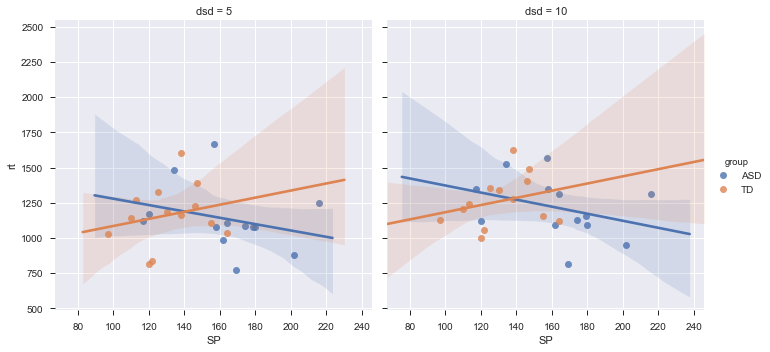

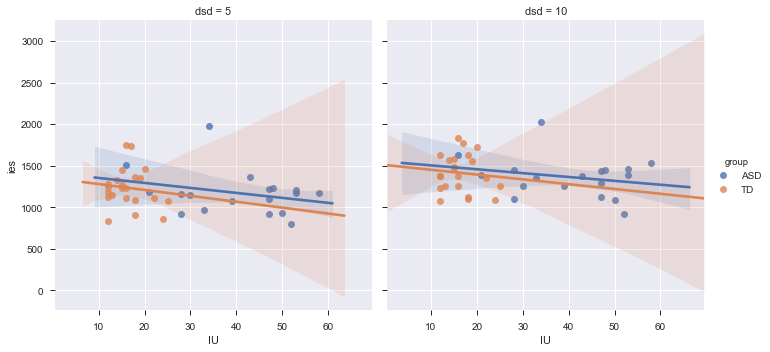

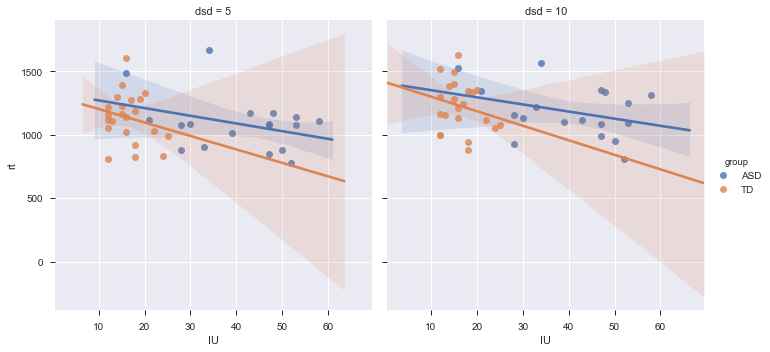

In [69]:
for i in ['SRS_TOTAAL', 'SP', 'IU']:

    sns.lmplot(x=i, y="ies", hue="group",
               col="dsd", data=dfsum);
    sns.lmplot(x=i, y="rt", hue="group",
           col="dsd", data=dfsumrt);


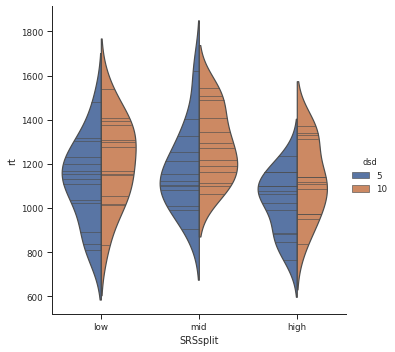

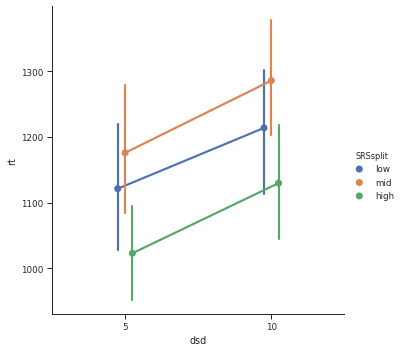

In [23]:
dfsumrtsrs = df.groupby(['SRSsplit', 'subjectId', 'dsd']).mean().reset_index()

sns.catplot(x="SRSsplit", y="rt", hue="dsd",
            kind="violin", split=True,inner="stick", data=dfsumrtsrs);
sns.catplot(x="dsd", y="rt", hue="SRSsplit", kind="point",dodge=.1, data=dfsumrtsrs);

This suggests some of the improved/faster visual search (found in other studies) is present here as well, at least for those with high autism traits (SRS & SP; not UI). Note that the variability in SRS in the TD group is smaller, which is to be expected (usual cutoff in 75). 

Adding this to the linear model indeed seems to make both group and SRS significant (in addition to dsd, and group*SRS). What's going on?


In [646]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ C(dsd) + tDist + group + C(dsd):group + group*SRS_TOTAAL", groups="subjectId",data=df[(df.correct==1)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                31731
Model:                                 GEE   No. clusters:                       41
Method:                        Generalized   Min. cluster size:                 470
                      Estimating Equations   Max. cluster size:                 851
Family:                           Gaussian   Mean cluster size:               773.9
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                      do, 12 sep 2019   Scale:                      373443.489
Covariance type:                    robust   Time:                         20:34:30
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1761.0589    183.709      9.586 

# Theoretical intermezzo: A possible divisive normalization account of visual search?

There is a divisive normalization (DN) account of visual search possible, working as a kind of winner-take-all process ('max-pooling', see Carandini & Heeger). The response on an item is normalized by energy in neighbouring items/units/neurons, which boosts outliers. See figure from Whitney, Haberman, Sweeney, 2014:

<img src="img/whitney2014.png" style="height:800px">

Intact performance may then be evidence for normal (non-reduced; contra Rosenberg et al) DN in ASD. It's interesting to speculate what the improved visual search in simple tasks in ASD means in that case. Does this mean that people with ASD only have a benefit if the 'contrast' can be computed very locally, ie if pooling across a larger region is necessary they are not better. Relatedly, Joseph et al 2009 found that visual search superiority in ASD is not caused by search processes (the way people deploy attention, sample the display) but by enhanced discrimination of targets from distractors ('preattentive').

What does this mean in DN terms? Do they have a stronger suppression 'weight' (kappa) but a smaller suppressive pool (g(i))? They perform the task on a more local level, but accentuate local differences stronger? And do they then cancel each other in the current task?

$\overline{{r}_{i}}={r}_{0}+{r}_{max}\frac{{[c\ast {f}_{i}(s)]}^{2}}{{c}_{50}^{2}+\kappa {[c\ast {g}_{i}(s)]}^{2}}$

(I got the idea of the increased weight from our study on orientation suppression and DN, where, if anything, there was more tilt illusion in some individuals with ASD. Because of the psychophysics involved, there were only 10 subjects in each group so we couldn't really examine this more.)

If so, can we see a signature of this in our visual search data? If we assume higher weighting => shorter search times, but pooling problems => longer search times.

- More accuracy for the shorter RTs in ASD (where the focus coincidentally lands on the target neighbourhood)? Especially in low dsd condition. When RTs are longer (overall, average RT was >1000ms, so most trials probably multiple saccades), worse accuracy?
- For shorter RTs, faster response in ASD than in TD? (without the need for large pooling, better search) For longer RTs, reversal of the difference? (with the need for pooling, slower, more serial?)

To be addressed in the distributional analyses below...

## What about predictive coding?
Note that there are interesting parallels between DN and precision(inverse variance)-weighting in predictive coding (PC) and some argue DN can function as one of the neural implementations of precision-weighting. See Lawson et al 2015: 

>"precision functions as a form of divisive normalization— where variance measured across a broad pool of perceptual regions and timescales acts as a denominator in a divisive computation—to scale or contextualize the driving neural responses to sensory input (not unlike dividing a difference in group means by its SE to form a t-statistic)."

The (precision) weight would then be determined by:
- The spatial (and temporal) scale on which activity is pooled (note that a smaller scale would make the estimate more unreliable due to noise)
- Weight (kappa above) given to this suppressive pool 

Both may be different across individuals, and some studies (e.g., Coen-Cagli et al., 2015) suggest they likely even vary within individuals, depending on context. Such flexible or adaptive weighting is evidently relevant in the context of HIPPEA (that posits a combi of less flexible and higher weights in ASD). The Nature Neuroscience study by Coen-Cagli et al. 

>"shows that it makes little sense for the context (neurons) to indiscriminately modulate a given neuron’s activity, when the extent to which context and (classical) receptive field are part of the same inferred cause (homogenous surface) varies in natural images. Hence, they argue that the strength of the suppression should be tuned flexibly based on a (Bayesian) inference on whether target and surround are actually homogeneous. This generalized, flexible DN model is shown to better fit the activity of V1 neurons than a conventional DN model, when applied to natural images. The inference on whether target and surround activity are caused by a common hidden cause in the input, makes the connection explicit with Bayesian accounts of perception, as well as with perceptual grouping or segmentation ...[]...inference on whether inputs derive from a common, homogeneous cause in space (a perceptual object) or in time (stationarity vs
volatility) are important on all levels of the hierarchy, not just in V1. This acknowledgement links the type of flexible gain control discussed here to the flexible gain regulation thought to be deficient in ASD according to recent predictive processing accounts of the disorder (2,44). In those models, the weight (or “precision”) of prediction errors needs to be lowered when it is inferred that those prediction errors derive from mere noise (so still the same hidden cause) or while the gain should be increased when they derive from an actual change in the environment (a different hidden cause)." (Van de Cruys et al. 2018)

The inference of homogeneity (of center and surround) may come from higher levels, parallelling the idea that (some of the) computations necessary for precision tuning come from higher cortical levels.

>"Optimal inference relies on combining the likelihood of the evidence (how likely  the  pattern  of  filters  outputs  arose  from  a  homogenous  or heterogeneous image) with prior knowledge about how often natural  images are homogeneous, according to Bayes’ rule" (Coen-Cagli et al. 2015). 

Evidently, the inference of homogeneity (expected variability=precision) is very relevant for our visual search task as well (~figure-ground segregation). Such higher level must get inputs from multiple units (cf. "Silencing areas V2 and V3 reduces surround suppression in primate V1"; Pennartz et al 2019). The expected homogeneity estimates (what counts as homogeneous) are tuned across displays (see Repetition effect below). Hence, faster reaction times with subsequent trials that have the same distractor distribution. If so this integration might also need more time, so create higher reaction times.

That said there are differences in computational setting of DN and precision-weighting (which Friston's group hasn't addressed):
- One could say the suppression pool in DN is a form of prior (originating within a visual level, as in Rao & Ballard), a 'prediction' that removes redundancy (information already present in the surround). In that case the divisive suppression in DN stands in contrast to the subtractive suppression in PC (ie prediction minus sensory input). But see Spratling's model.
- Also, PC talks about representing sufficient statistics (mean and variance, predicted state and precision), while DN is formulated within a population coding framework. Don't know whether these are easily reconciled.


# Response Time Distributional Analyses

Some of the text and code below is copied from [Erik Marsja](https://www.marsja.se/response-time-distributions-using-python/)

Balota, D. a., & Yap, M. J. (2011). Moving Beyond the Mean in Studies of Mental Chronometry: The Power of Response Time Distributional Analyses. Current Directions in Psychological Science, 20(3), 160–166. http://doi.org/10.1177/0963721411408885

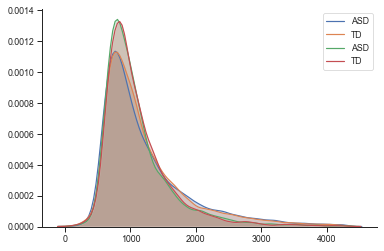

In [245]:
fig, ax = plt.subplots()
groups = ['ASD', 'TD']

for group in groups:
    condition_data = df[(df['group'] == group) & (df['correct']==1) & (df.dsd==10)]['rt']
    sns.kdeplot(condition_data, shade=True, label=group)
    
sns.despine()

for group in groups:
    condition_data = df[(df['group'] == group) & (df['correct']==1) & (df.dsd==5)]['rt']
    sns.kdeplot(condition_data, shade=True, label=group)
    
sns.despine()

Note the imbalance in datapoints, inherent to the design. Much more datapoints for dsd=10

In [246]:
print(df[(df.correct==1)].groupby(['group','dsd']).rt.count())

group  dsd
ASD    5       4324
       10     14727
TD     5       4170
       10     14616
Name: rt, dtype: int64


## Cumulative distribution function of rts

In [587]:
def cdf(df, conditions=['congruent', 'incongruent']):

    data = {i: df[(df.dsd == conditions[i])] for i in range(len(
        conditions))}
    plot_data = []

    for i, condition in enumerate(conditions):

        rt = data[i].rt.sort_values()
        yvals = np.arange(len(rt)) / float(len(rt))

        # Append it to the data
        cond = [condition]*len(yvals)

        df = pd.DataFrame(dict(dens=yvals, dv=rt, condition=cond))
        plot_data.append(df)

    plot_data = pd.concat(plot_data, axis=0)

    return plot_data

In [588]:
def cdf_plot(cdf_data, save_file=False, legend=True):
    sns.set_style('white')
    sns.set_style('ticks')
    g = sns.FacetGrid(cdf_data, hue="condition", size=8)
    g.map(plt.plot, "dv", "dens", alpha=.7, linewidth=1)
    if legend:
        g.add_legend(title="dsd")
    g.set_axis_labels("Response Time (ms.)", "Probability")
    g.fig.suptitle('Cumulative density functions')

    if save_file:
        g.savefig("cumulative_density_functions_seaborn_python_response"
                  "-time.png")

    plt.show()

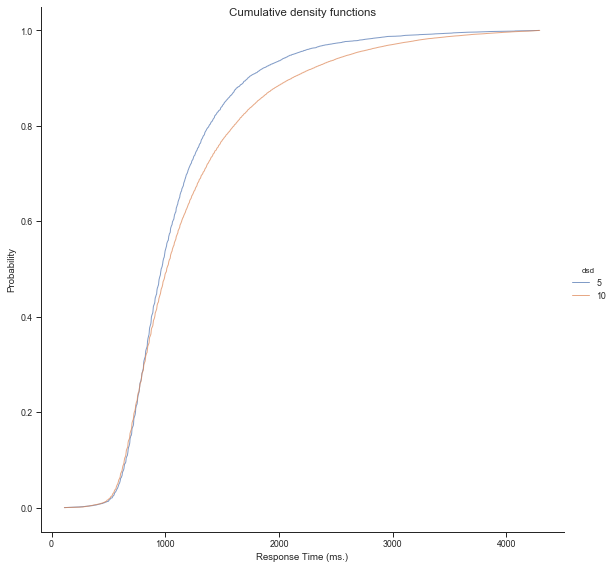

In [589]:
cdf_dat = cdf(df[(df.correct==1) ], conditions=[5,10])
cdf_plot(cdf_dat, legend=True, save_file=False)

## Conditional Accuracy Functions

Conditional accuracy functions (CAF) is a technique that also incorporates the accuracy in the task. Creating CAFs involve binning your data (e.g., the response time and accuracy) and creating a linegraph. Briefly, CAFs can capture patterns related to speed/accuracy trade-offs (see Richard, 2014).

Richard, P. (2014). The speed-accuracy tradeoff : history , physiology , methodology , and behavior. Frontiers in Neuroscience, 8(June), 1–19. http://doi.org/10.3389/fnins.2014.00150

In [3]:
def calc_caf(df, subid, rt, acc, condition, quantiles=[0.25, 0.50, 0.75, 1]):
    """
    Calculates conditional accuracy functions (CAF) per subject and agregates into 
    one CAF. 
    
    Parameters
    ----------
    df : pandas dataframe
        A subset containing the data from one of the conditions
    subid : string
        Contains the colum name with the subject identifier
    rt : string 
        column name for column containing the response/reaction times
    acc : string  
        column name for column containing the accuracy data
    condition :string 
        column name for column containing the conditions identfiers
    quantiles: list 
        contains the quantiles (e.g., [0.25, 0.50, 0.75, 1])

    Returns
    -------
        a multi-indexed pandas data frame

    Examples:
     incongr = frame[(frame.TrialType == 'incongruent)]
     incongr_caf = calc_caf(incongr, "SubID", "RT", "ACC", "incongruent")
    """

    # Subjects
    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()

    # Multi-index frame for data:
    arrays = [np.array(['rt'] * len(quantiles) + ['acc'] * len(quantiles)),
              np.array(quantiles * 2)]

    data_caf = pd.DataFrame(columns=subjects, index=arrays)

    # Calculate CAF for each subject
    for subject in subjects:

        sub_data = df.loc[(df[subid] == subject)]

        subject_cdf = sub_data[rt].quantile(q=quantiles).values

        # calculate mean response time and proportion of error for each bin
        for i, q in enumerate(subject_cdf):

            quantile = quantiles[i]

            # First quantile
            if i < 1:
                # Subset
                temp_df = sub_data[(sub_data[rt] < subject_cdf[i])]
                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()
                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

            # Second  & third quantile
            elif i == 1 or i < len(quantiles):

                # Subset
                temp_df = sub_data[(sub_data[rt] > subject_cdf[i - 1]) & (
                    sub_data[rt] < q)]
                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()

                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

            # Last quantile MAY WANT TO CHANGE THIS
            elif i == len(quantiles):
                # Subset
                temp_df = sub_data[(sub_data[rt] > subject_cdf[i])]

                # RT
                data_caf.loc[('rt', quantile)][subject] = temp_df[rt].mean()

                # Accuracy
                data_caf.loc[('acc', quantile)][subject] = temp_df[acc].mean()

    # Aggregate subjects CAFs
    data_caf = data_caf.mean(axis=1).unstack(level=0)

    # Add trialtype
    data_caf['trialtype'] = [condition for _ in range(len(quantiles))]

    return data_caf


def caf_plot(df, save_file=False, im_size=6):
    """
    Plotting the conditional accuracy functions (CAF)
    
    Parameters
    ----------
    df : pandas dataframe 
        containing the CAF(s) calculated with calc_caf
    save_file : boolean
        True if planning to save file
    im_size : integer
        Size of the image (i.e., the plot)
        
    Examples
    --------
    incongr = frame[(frame.TrialType == 'incongruent)]
    incongr_caf = calc_caf(incongr, "SubID", "RT", "ACC", "incongruent")
    caf_plot(incongr_caf)
    """
    sns.set_style('white')
    sns.set_style('ticks')

    g = sns.FacetGrid(df, hue="trialtype", size=im_size, ylim=(0, 1.1))
    g.map(plt.scatter, "rt", "acc", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "rt", "acc", alpha=.7, linewidth=1)
    g.add_legend(title="Group")
    g.set_axis_labels("Response Time (ms.)", "Accuracy")
    g.fig.suptitle('Conditional Accuracy Functions')
    plt.ylim(.5, 1)


    if save_file:
        g.savefig("conditional_accuracy_function_seaborn_python_response"
                   "-time.png")

    plt.show()




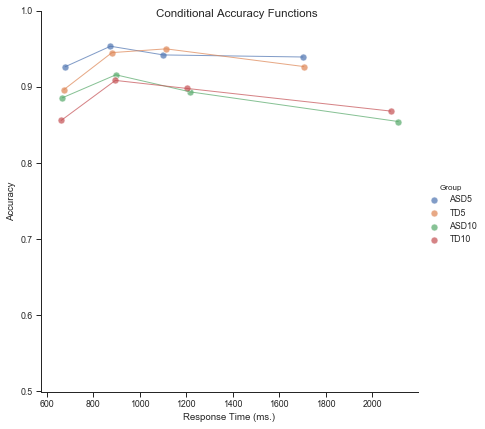

In [251]:
# Conditional accuracy function (data) for incongruent and congruent conditions
ASD5 = calc_caf(df[(df.group == "ASD") & (df.dsd == 5)], "subjectId", "rt", "correct",
               "ASD5")
TD5 = calc_caf(df[(df.group == "TD") & (df.dsd == 5)], "subjectId", "rt", "correct",
               "TD5")
ASD10 = calc_caf(df[(df.group == "ASD") & (df.dsd == 10)], "subjectId", "rt", "correct",
               "ASD10")
TD10 = calc_caf(df[(df.group == "TD") & (df.dsd == 10)], "subjectId", "rt", "correct",
               "TD10")


#Combine the data and plot it
df_caf = pd.concat([ASD5, TD5, ASD10, TD10])

caf_plot(df_caf)

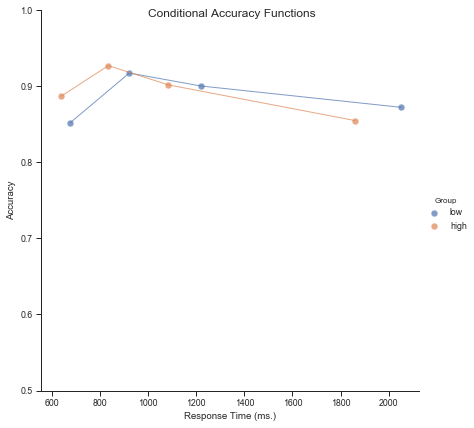

In [18]:
# Conditional accuracy function (data) for incongruent and congruent conditions
low = calc_caf(df[(df.SRSsplit == "low")], "subjectId", "rt", "correct",
               "low")
high = calc_caf(df[(df.SRSsplit == "high")], "subjectId", "rt", "correct",
               "high")


#Combine the data and plot it
df_caf = pd.concat([low,high])

caf_plot(df_caf)

In [17]:
print(df.rt.quantile(.20))

print(df[df.rt<df.rt.quantile(.20)].groupby(['group']).rt.count())

# model formulation
fml = "correct ~ dsd * group"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subjectId", df[df.rt<df.rt.quantile(.20)], cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())


723.318781299
group
ASD    4385
TD     4176
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                     correct   No. Observations:                 8561
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                  11
                      Estimating Equations   Max. cluster size:                 502
Family:                           Binomial   Mean cluster size:               174.7
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Tue, 24 Sep 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         13:29:38
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept

## Delta plots

Delta plots (DPs) can be used to visualize and compare response time quantiles obtained under two experimental conditions. DPs enable examination whether the experimental manipulation has a larger effect on the relatively fast responses or on the relatively slow ones (e.g., Speckman, Rouder, Morey, & Pratte, 2008).

Speckman, P. L., Rouder, J. N., Morey, R. D., & Pratte, M. S. (2008). Delta Plots and Coherent Distribution Ordering. The American Statistician, 62(3), 262–266. http://doi.org/10.1198/000313008X333493

In [4]:
def calc_delta_data(df, subid, rt, condition, conditions=['incongruent',
                                                   'congruent']):
    """
    Calculating the data for creating delta plots. That is, binning
    the response time and accuracy data in deciles. First each subjects
    data is binned. Then the binned data is avaraged.
    
    Parameters
    ----------
    df : pandas dataframe
        Data to bin.
    subid : string
        Column name for column with the subject identfier
    rt : string
        Column name for column with the response times
    condition : string
        Column name for column with the conditions
    conditions : list
        Containing string of the conditions in the experiment
        
    Returns
    -------
    delta_data: Dataframe
        Binned avarage response time and response time diff b/w conditions 
        
    Examples
    --------
    d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])
    
    """


    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()

    deciles = np.arange(0.1, 1., 0.1)

    cond_one = conditions[0]
    cond_two = conditions[1]

    # Frame to store the data (per subject)
    arrays = [np.array([cond_one, cond_two]).repeat(len(deciles)),
              np.array(deciles).tolist() * 2]
    data_delta = pd.DataFrame(columns=subjects, index=arrays)

    for subject in subjects:

        sub_data_inc = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_one)]
        sub_data_con = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_two)]

        inc_q = sub_data_inc[rt].quantile(q=deciles).values
        con_q = sub_data_con[rt].quantile(q=deciles).values
        for i, dec in enumerate(deciles):
            data_delta.loc[(cond_one, dec)][subject] = inc_q[i]
            data_delta.loc[(cond_two, dec)][subject] = con_q[i]


    # Aggregate deciles
    data_delta = data_delta.mean(axis=1).unstack(level=0)
    # Calculate difference
    data_delta['Diff'] = data_delta[cond_one] - data_delta[cond_two]
    # Calculate average
    data_delta['Average'] = (data_delta[cond_one] + data_delta[cond_two]) / 2

    return data_delta


def delta_plot(delta_data, group=None, save_file=False, im_size=6):
    """
    Delta plot
    
    Parameters
    ----------
    delta_data : pandas dataframe
        Binned avarage response time and response time diff b/w conditions 
    save_file : boolean
        True if file (.png) of plot is going to be saved
    im_size : integer
        Size of the image (i.e., the plot)
        
    Examples
    -------
    d = calc_delta_data(frame, "SubID", "RT", "TrialType", ['incongruent',
                                                       'congruent'])
    delta_plot(d, save_file=True)
    """

    ymax = delta_data['Diff'].max() + 10
    ymin = delta_data['Diff'].min() - 10
    xmin = delta_data['Average'].min() - 20
    xmax = delta_data['Average'].max() + 20

    g = sns.FacetGrid(delta_data, hue=group, ylim=(ymin, ymax), xlim=(xmin, xmax),
                      size=im_size)
    g.map(plt.scatter, "Average", "Diff", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "Average", "Diff", alpha=.7, linewidth=1)
    ax = g.axes[0]
    ax[0].axhline(0, ls='--', color='black')
    g.set_axis_labels("Average RTs (ms)", "Effect (ms)")
    if group: g.add_legend(title=group)
    g.fig.suptitle('Delta Plot')
    if save_file:
        g.savefig("delta_plot_seaborn_python_response-time.png")
    

Usually applied on within-subject variable, but also applicable here?

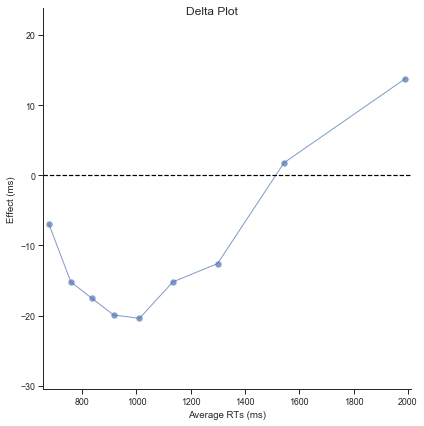

In [30]:
d_data = calc_delta_data(df[(df.correct==1)], "subjectId", "rt", "group", ['ASD','TD'])
delta_plot(d_data)

We see a reversal of the effect. ASD is faster for the short RTs (consistent with earlier work on visual search in ASD), but slower in the higher RTs.

> "If all decile classes have faster mean in one group than in the other, we say that there is coherent mean ordering and that one group stochastically dominates the other in mean... Violations of coherent orderings of mean are diagnostic signatures of complex effects (such as the presence of multiple processes or mixtures) and suggest further avenues of study." (Speckman et al. 2008)

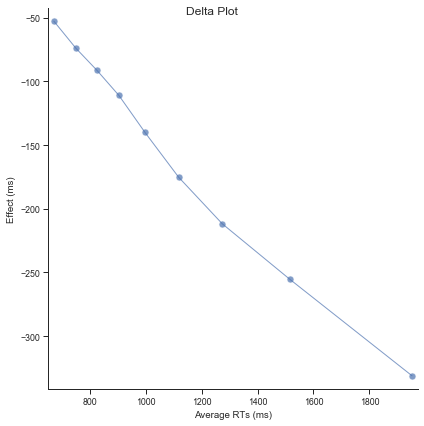

In [36]:
d_data = calc_delta_data(df[(df.correct==1)], "subjectId", "rt", "SRSsplit", ['high','mid'])
delta_plot(d_data)

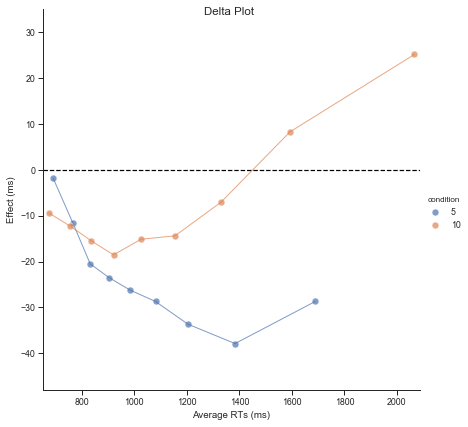

In [566]:
# Calculate delta plot data and plot it
d_data5 = calc_delta_data(df[(df.correct==1) & (df.dsd == 5)], "subjectId", "rt", "group", ['ASD','TD'])
d_data5['condition']=5
d_data10 = calc_delta_data(df[(df.correct==1) & (df.dsd == 10)], "subjectId", "rt", "group", ['ASD','TD'])
d_data10['condition']=10

d_data = pd.concat([d_data5, d_data10])
delta_plot(d_data, group='condition')

ASD is consistently but slightly better across the board in the low variability condition. However, in the high variability condition we see the reversal. This might explain the lack of main effect of group in the linear model. 

In [27]:
print(df.rt.quantile(.5))

print(df[df.rt<df.rt.quantile(.5)].groupby(['group']).rt.count())

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ group * dsd", groups="subjectId",data=df[(df.rt>df.rt.quantile(.5)) & (df.correct==1)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())
print(result1.cov_struct.summary())

996.7658626265
group
ASD    10677
TD     10453
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                18841
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                 141
                      Estimating Equations   Max. cluster size:                 652
Family:                           Gaussian   Mean cluster size:               392.5
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                      vr, 27 sep 2019   Scale:                      398804.766
Covariance type:                    robust   Time:                         17:23:59
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Interc

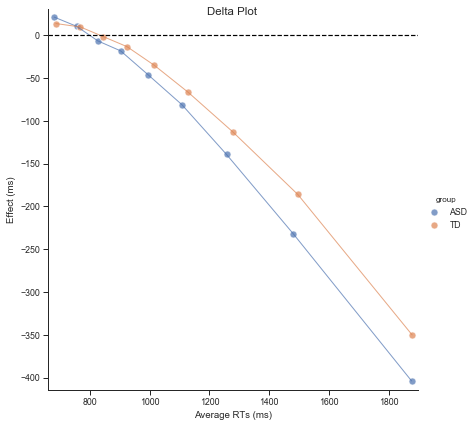

In [567]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(df[(df.correct==1) & (df.group == 'ASD')], "subjectId", "rt", "dsd", [5,10])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(df[(df.correct==1) & (df.group == 'TD')], "subjectId", "rt", "dsd", [5,10])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')

Could we model these kinds of plots with DN? If so, can we discriminate whether this is the effect of a difference in the suppression weight or the suppressive pool (or a particular combination of both)?

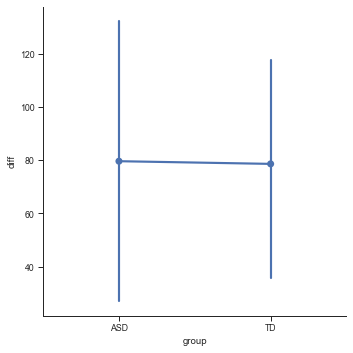

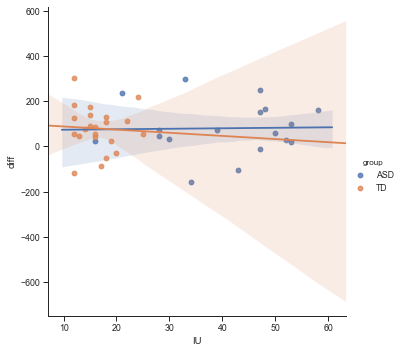

In [580]:
dfdsdsum =  df.query("previous_correct==1 & correct==1").groupby(['group','subjectId', 'dsd']).mean().reset_index()

dsddiff = dfdsdsum.pivot_table(index=['group','subjectId','IU'],columns='dsd',values='rt').reset_index()

dsddiff['diff']= dsddiff[10] - dsddiff[5]



g = sns.catplot(x="group", y="diff", units='subjectId', kind="point", data=dsddiff, dodge=.2);


sns.lmplot(x="IU", y="diff", hue="group", data=dsddiff);

# Check evolution of rts over learning and test phase

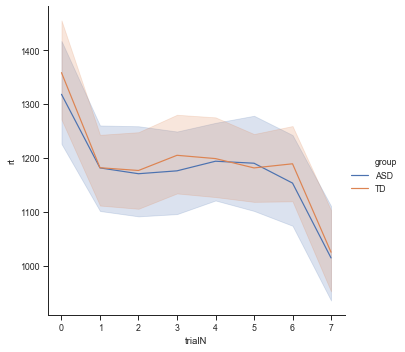

In [34]:
dfsumtrials = df.query('correct==1 & previous_correct==1').groupby(['subjectId', 'group','dsd', 'trialN']).rt.mean().reset_index()

dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==0)]=6
dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==1)]=7
sns.relplot(x="trialN", y="rt", hue="group", kind="line", data=dfsumtrials);

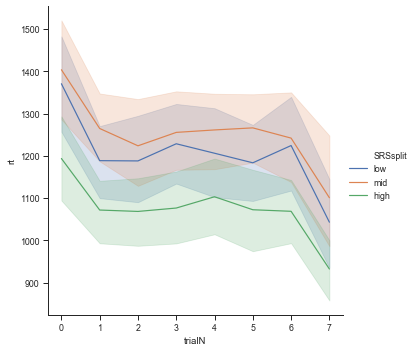

In [35]:
dfsumtrials = df.query('correct==1 & previous_correct==1').groupby(['subjectId', 'SRSsplit','dsd', 'trialN']).rt.mean().reset_index()

dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==0)]=6
dfsumtrials.trialN[(dfsumtrials.dsd==5) & (dfsumtrials.trialN==1)]=7
sns.relplot(x="trialN", y="rt", hue="SRSsplit", kind="line", data=dfsumtrials);

# Repetition effect (learning within prime streaks)

Does repeated presentation of the same distraction distribution (learning the distraction distribution) improve detection speed, accuracy?

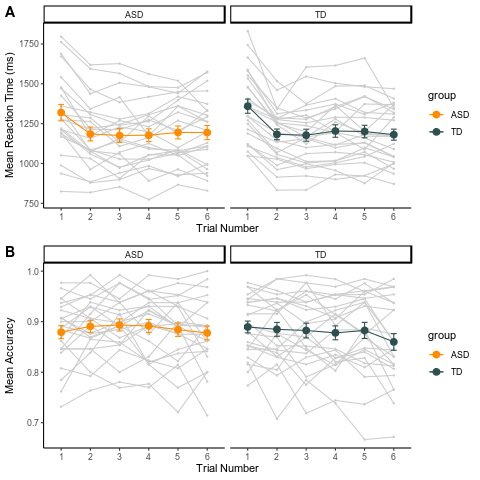

In [48]:
%%R

RT_trial <- df_filter %>%
  filter(correct==1) %>% #only correct responses
  filter(previous_correct == 1)  %>% #only when previous trial was correct (post-error slowdown)
  filter(dsd==10) %>% #prime trials
  group_by(subjectId, group, dsd,trialN) %>% 
  summarise(mean_rt=mean(rt),sd_rt=sd(rt), mean_log_rt=mean(log_rt), sd_log_rt = sd(log_rt))

#Plot RTs over trials within prime streaks
RT_repetition_plot<- ggplot(RT_trial,aes(x=as.factor(trialN),y=mean_rt, color = group)) +
geom_point(size=0.5, colour = "gray80") + #Individual data points 
geom_line(aes(group=subjectId), colour = "gray80") + #lines between individual data points
stat_summary(fun.y=base::mean, geom="point", size =3) + # points for means per group
stat_summary(fun.y=base::mean, geom="line",aes(group=group)) + #lines between points for means per group
stat_summary(fun.data = "mean_se", geom="errorbar", width = 0.2) + #Standard error errorbars
facet_grid(~group) +#Per group
xlab("Trial Number") + ylab("Mean Reaction Time (ms)") +    #axis titles
theme_classic() + 
scale_color_manual(values=c("darkorange", "darkslategrey")) + #colors
theme(plot.title = element_text(hjust = 0.5)) + # Center titles
scale_x_discrete(labels=c("0" = "1", "1" = "2", "2" = "3","3" = "4","4"= "5","5" = "6")) #Rename x-axis labels

#same for accuracy
acc_trial<- df_filter %>%
  filter(dsd== 10) %>%
  group_by(subjectId,group,trialN) %>%
  summarise(mean_acc=mean(correct),sd_acc=sd(correct))

acc_repetition_plot<-ggplot(acc_trial,aes(x=as.factor(trialN),y=mean_acc, color = group))+ geom_point(size=0.5, colour = "gray80")  + geom_line(aes(group=subjectId), colour = "gray80") + stat_summary(fun.y=base::mean, geom="point", size =3) + stat_summary(fun.y=base::mean, geom="line",aes(group=group)) + stat_summary(fun.data = "mean_se", geom="errorbar", width = 0.2) +  facet_grid(~group) +
  xlab("Trial Number") + ylab("Mean Accuracy")   + theme_classic() + scale_color_manual(values=c("darkorange", "darkslategrey"))+
  theme(plot.title = element_text(hjust = 0.5))+ scale_x_discrete(labels=c("0" = "1", "1" = "2",
                              "2" = "3","3" = "4","4"= "5","5" = "6"))

plot_grid(RT_repetition_plot, acc_repetition_plot, labels = "AUTO", align ='v', ncol=1)

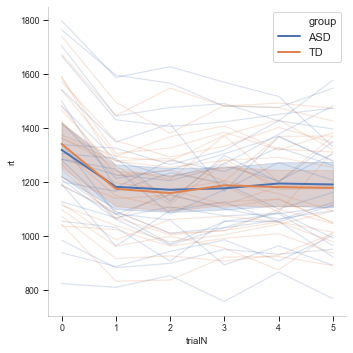

In [257]:
dfsumrep = df.query('correct==1 & previous_correct==1 & dsd==10').groupby(['subjectId', 'group', 'trialN']).rt.mean().reset_index()
g = sns.relplot(x="trialN", y="rt", hue="group", kind="line",units='subjectId', data=dfsumrep, estimator=None, legend=False);
plt.setp([g.ax.get_children()],alpha=.2)
sns.set(style="ticks", rc={"lines.linewidth": 2})
sns.lineplot(x="trialN", y="rt", hue="group", data=dfsumrep);

## Helmert contrasts comparing each level with the mean of the next levels

In [88]:
%%R

PRIME_TR <- df_filter %>%
  filter(correct==1) %>% #Only correct trials
  filter(previous_correct == 1) %>% #Previous trial correct to account for post-error slowdown
  filter(dsd==10) #Only prime trials

PRIME_TR$trialN = factor(PRIME_TR$trialN)

my.helmert = matrix(c(5,-1,-1,-1,-1,-1,0,4,-1,-1,-1,-1,0,0,3,-1,-1,-1,0,0,0,2,-1,-1,0,0,0,0,1,-1), ncol = 5) #Make my own helmert contrast matrix, because build-in version is actually reverse Helmert contrast

lmer_RT_TD<-lmer(log_rt ~ trialN * group + (trialN|subjectId), data= PRIME_TR, contrasts = list(trialN = my.helmert))
summary(lmer_RT_TD)

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_rt ~ trialN * group + (trialN | subjectId)
   Data: PRIME_TR

REML criterion at convergence: 31731.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5042 -0.7321 -0.1755  0.5994  3.8263 

Random effects:
 Groups    Name        Variance  Std.Dev. Corr                         
 subjectId (Intercept) 0.0273030 0.16524                               
           trialN1     0.0001007 0.01003  -1.00                        
           trialN2     0.0002939 0.01714  -0.67  0.67                  
           trialN3     0.0006150 0.02480  -0.44  0.44  0.96            
           trialN4     0.0007192 0.02682  -0.54  0.54  0.99  0.99      
           trialN5     0.0009800 0.03130  -0.49  0.49  0.98  1.00  1.00
 Residual              0.1837829 0.42870                               
Number of obs: 27459, groups:  subjectId, 49

Fixed effects:
                  Estimate Std. Error       

In [415]:
%%R

df_acc<- df_filter%>%
  filter(dsd== 10)%>%
  mutate(trialN = factor(trialN))

acc_trial$trialN = factor(acc_trial$trialN)

glmer_acc<-glmer(correct ~ trialN*group + (trialN|subjectId),family = binomial, data = df_acc,contrasts = list(trialN = my.helmert))
summary(glmer_acc)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ trialN * group + (trialN | subjectId)
   Data: df_acc

     AIC      BIC   logLik deviance df.resid 
 23608.6  23887.3 -11771.3  23542.6    34265 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5142  0.2212  0.3241  0.4115  0.6645 

Random effects:
 Groups    Name        Variance Std.Dev. Corr                    
 subjectId (Intercept) 0.33992  0.5830                           
           trialN1     0.03033  0.1741   0.32                    
           trialN2     0.08564  0.2926   0.07 0.72               
           trialN3     0.04687  0.2165   0.25 0.99 0.82          
           trialN4     0.08414  0.2901   0.32 0.99 0.62 0.96     
           trialN5     0.01671  0.1293   0.52 0.89 0.34 0.81 0.94
Number of obs: 34298, groups:  subjectId, 49

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)

A quick decrease in reaction times after one trial with distractors sampled from the same Gaussian distribution in both groups (no difference between groups) and no change in average accuracy over trial number. Little additional learning after second trial in streak. Confirmed by distributional analysis? 

## RT Distributional analyses 

Care in interpretation because fewer trials (+-2500 per trialN in each group, +-100 per participant).

group  trialN
ASD    0         2505
       1         2388
TD     0         2489
       1         2408
Name: rt, dtype: int64
group  trialN
ASD    1         2388
       2         2434
TD     1         2408
       2         2393
Name: rt, dtype: int64
group  trialN
ASD    2         2434
       3         2428
TD     2         2393
       3         2380
Name: rt, dtype: int64
group  trialN
ASD    3         2428
       4         2404
TD     3         2380
       4         2394
Name: rt, dtype: int64
group  trialN
ASD    4         2404
       5         1182
TD     4         2394
       5         1158
Name: rt, dtype: int64
group  trialN
ASD    1         2388
       4         2404
TD     1         2408
       4         2394
Name: rt, dtype: int64


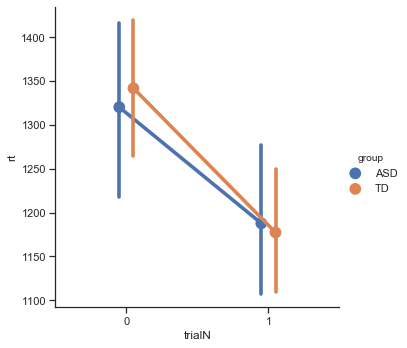

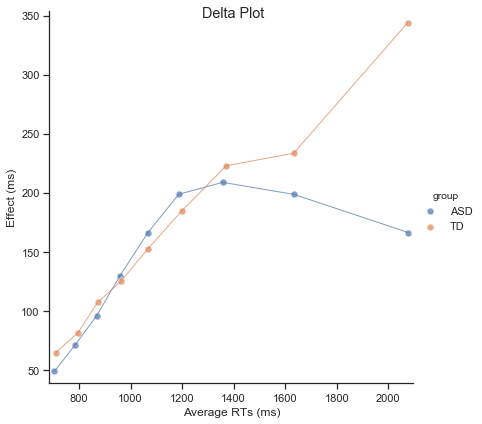

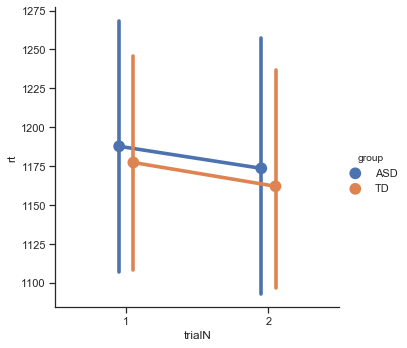

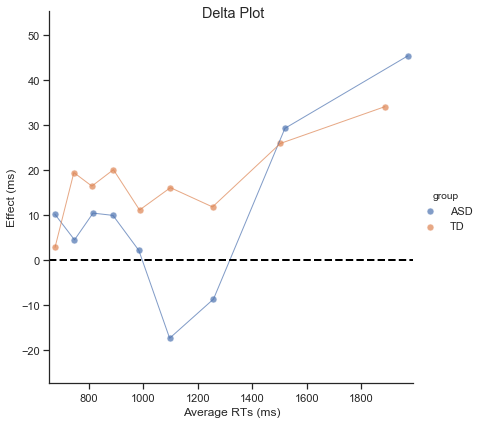

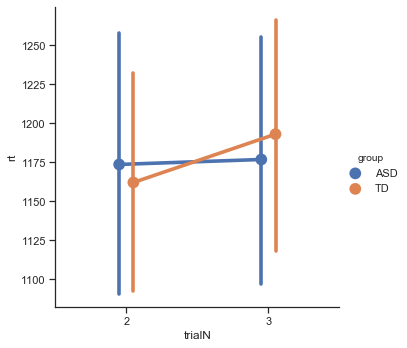

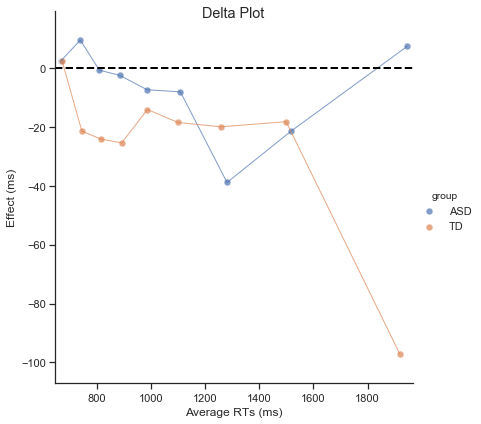

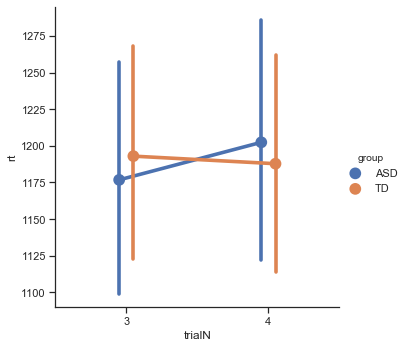

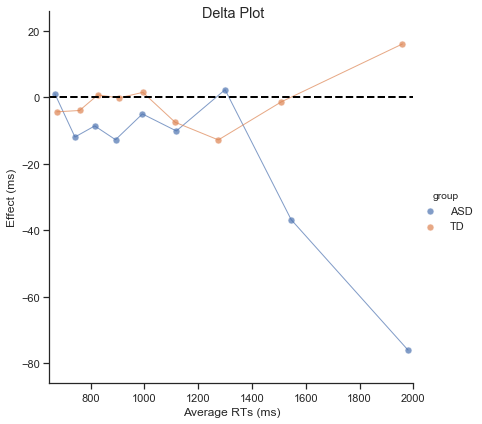

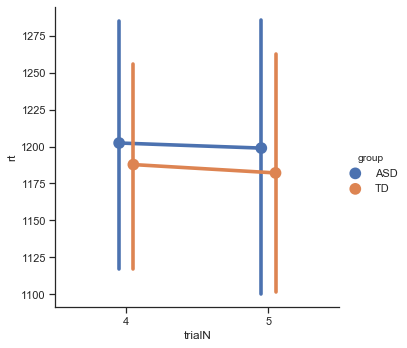

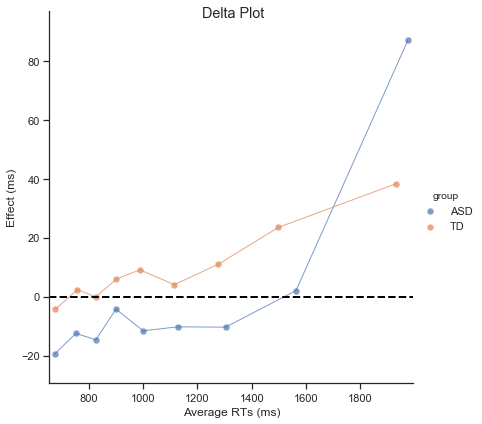

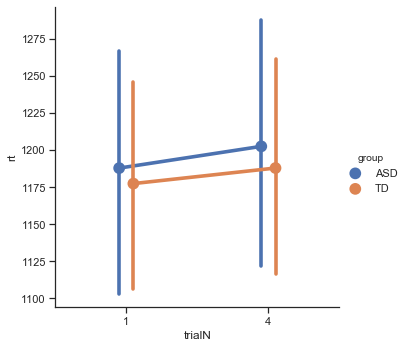

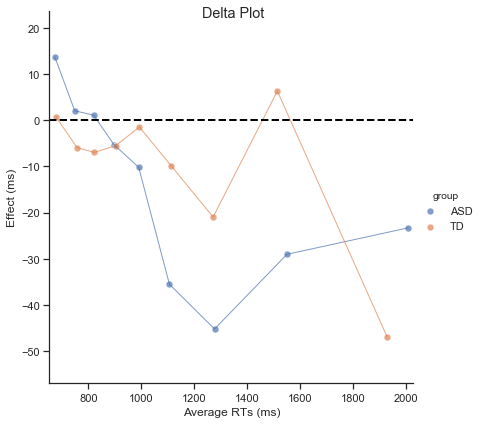

In [258]:
compTrials = [(0,1),(1,2),(2,3),(3,4),(4,5),(1,4)]

for i in compTrials:
    
    dfDL = df[((df.trialN==i[0]) | (df.trialN==i[1])) & (df.correct==1) & (df.previous_correct == 1) & (df.dsd == 10)]
    print(dfDL.groupby(['group','trialN']).rt.count())
    sns.catplot(x="trialN", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);
     
    # Calculate delta plot data and plot it
    d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "trialN", [i[0],i[1]])
    d_dataASD['group']='ASD'
    d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "trialN", [i[0],i[1]])
    d_dataTD['group']='TD'
    d_data = pd.concat([d_dataASD, d_dataTD])
    
    delta_plot(d_data, group='group')



Comparing trials 1-2 with trials 3-4 to see if there is any more learning after first trial:

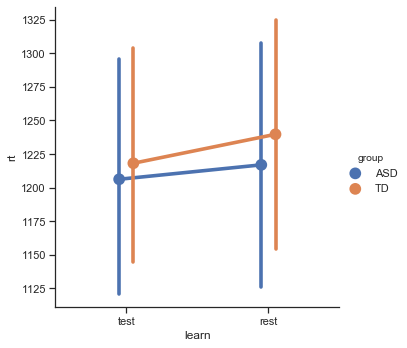

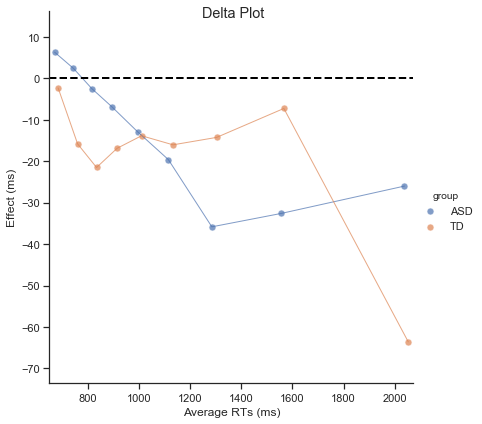

In [380]:

dfDL = df[(df.trialN!=0) & (df.correct==1) & (df.previous_correct == 1) & (df.dsd == 10)]

def learngroups(series):
    if series < 3:
        return "test"
    elif 3 <= series < 5:
        return "rest"
    
dfDL['learn'] = dfDL['trialN'].apply(learngroups)

#dfDL['learn']= np.where(dfDL['trialN'] in [1,2], 'test', 'rest')
sns.catplot(x="learn", y="rt", hue="group", units='subjectId', kind="point", dodge=.1, data=dfDL);

# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "learn", ['test','rest'])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "learn", ['test','rest'])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')



## Interim conclusion

The doesn't seem much extra learning beyond the first repeat of distractor distribution. Improvement of search times with repeated presentations is something also found in contextual cueing. However there spatial outlay of distractors relative to target is kept the same (is learnt) instead of the distribution of a feature of the distractor. Also, repeated trials are interspersed with random trials, the learning takes place across many repeats (vs single repeat here), and the effect is generally smaller (even after many repeats) than found here. Still, also in those settings, (implicit) learning is intact in ASD (confirmed in several studies).

# Transition from prime to probe sequence

group  transprime
ASD    0.0           2380
       1.0           2505
TD     0.0           2359
       1.0           2470
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 9714
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                 126
                      Estimating Equations   Max. cluster size:                 248
Family:                           Gaussian   Mean cluster size:               202.4
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Tue, 01 Oct 2019   Scale:                      333905.124
Covariance type:                    robust   Time:                         15:10:02
                             coef    std err          z      P>|z|      [0.025      0.975]
--------

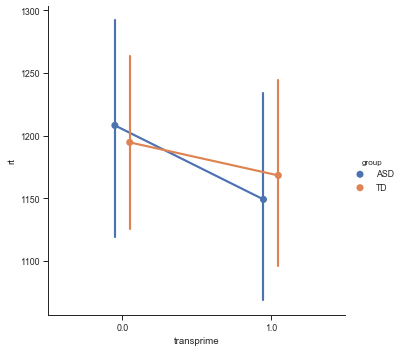

In [14]:

dfDL = df[((df.transprime==0) | (df.transprime==1)) & (df.correct==1) & (df.previous_correct == 1)]
print(dfDL.groupby(['group','transprime']).rt.count())
sns.catplot(x="transprime", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ transprime * group", groups="subjectId",data=dfDL, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())
print(result1.cov_struct.summary())

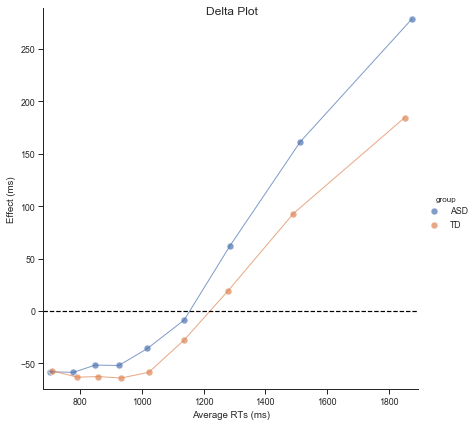

In [15]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "transprime", [0,1])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "transprime", [0,1])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])
delta_plot(d_data, group='group')

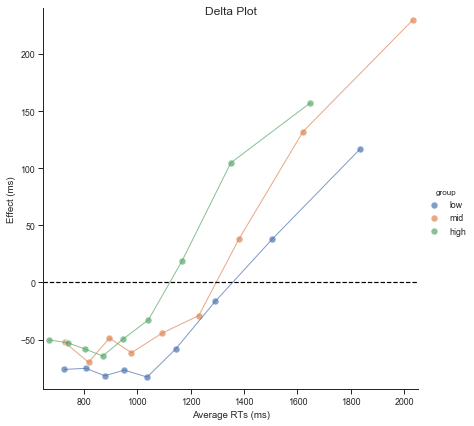

In [16]:
# Calculate delta plot data and plot it
d_datalow = calc_delta_data(dfDL[(dfDL.SRSsplit == 'low')], "subjectId", "rt", "transprime", [0,1])
d_datalow['group']='low'
d_datahigh = calc_delta_data(dfDL[(dfDL.SRSsplit == 'high')], "subjectId", "rt", "transprime", [0,1])
d_datahigh['group']='high'
d_datamid = calc_delta_data(dfDL[(dfDL.SRSsplit == 'mid')], "subjectId", "rt", "transprime", [0,1])
d_datamid['group']='mid'

d_data = pd.concat([d_datalow, d_datamid, d_datahigh])
delta_plot(d_data, group='group')

In [72]:
print(dfDL.groupby(['group','transprime']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime', 'in_range']).rt.mean())
print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group','transprime', 'in_range']).rt.count())

group  transprime
ASD    0.0           1208.285223
       1.0           1149.253689
TD     0.0           1199.547517
       1.0           1178.897397
Name: rt, dtype: float64
group  transprime
ASD    0.0           764.819997
       1.0           800.622010
TD     0.0           773.967188
       1.0           806.754692
Name: rt, dtype: float64
group  transprime
ASD    0.0           764.819997
       1.0           800.622010
TD     0.0           773.967188
       1.0           806.754692
Name: rt, dtype: float64
group  transprime  in_range
ASD    0.0         in          755.899929
                   out         769.696597
       1.0         in          825.354496
                   out         783.587714
TD     0.0         in          774.209901
                   out         773.859283
       1.0         in          828.479796
                   out         791.516082
Name: rt, dtype: float64
group  transprime  in_range
ASD    0.0         in          439
                   out         

In [22]:

print(dfDL.rt.quantile(.5))

print(dfDL[dfDL.rt<dfDL.rt.quantile(.5)].groupby(['group']).rt.count())

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ transprime * group * in_range", groups="subjectId",data=dfDL[dfDL.rt<dfDL.rt.quantile(.5)], family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())
print(result1.cov_struct.summary())

1010.068102565
group
ASD    2499
TD     2358
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 4857
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                  25
                      Estimating Equations   Max. cluster size:                 178
Family:                           Gaussian   Mean cluster size:               101.2
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Tue, 01 Oct 2019   Scale:                       18059.784
Covariance type:                    robust   Time:                         15:12:14
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

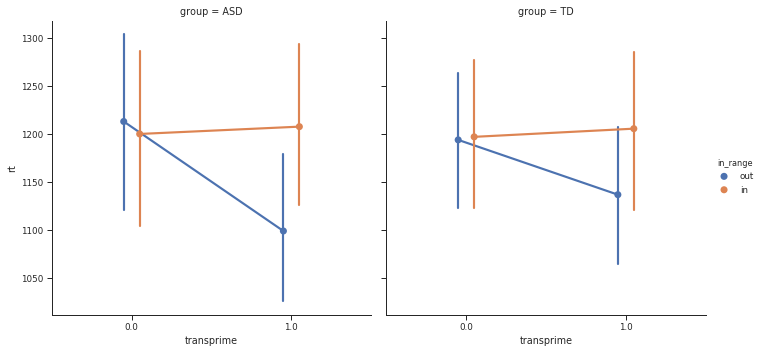

In [30]:
sns.catplot(x="transprime", y="rt", hue="in_range", col='group', units='subjectId', kind="point",dodge=.1, data=dfDL);


### Interim conclusion
There's an effect of transition from prime to probe trials in the lower half and higher half of rts, but it is reversed. People are slower after switch in the short reaction times (because of target that is in old distractor dist range?), but faster after switch in the long reaction times (because lower dsd?).

## Accuracy

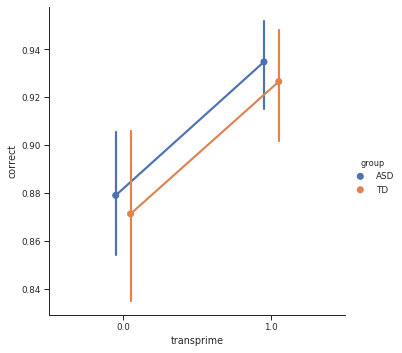

In [31]:
sns.catplot(x="transprime", y="correct", hue="group", units='subjectId', kind="point",dodge=.1, data=df);

In [32]:
# model formulation
fml = "correct ~ transprime * group"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subjectId", df, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                     correct   No. Observations:                12113
Model:                                 GEE   No. clusters:                       48
Method:                        Generalized   Min. cluster size:                 245
                      Estimating Equations   Max. cluster size:                 258
Family:                           Binomial   Mean cluster size:               252.4
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 24 Sep 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         13:53:17
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.9850      0.111     17.860      0

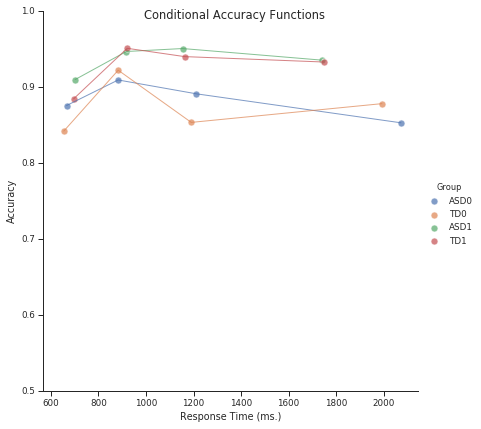

In [35]:

# Conditional accuracy function (data) for incongruent and congruent conditions
ASD0 = calc_caf(df[(df.group == "ASD") & (df.transprime == 0)], "subjectId", "rt", "correct",
               "ASD0")
TD0 = calc_caf(df[(df.group == "TD") & (df.transprime == 0)], "subjectId", "rt", "correct",
               "TD0")
ASD1 = calc_caf(df[(df.group == "ASD") & (df.transprime == 1)], "subjectId", "rt", "correct",
               "ASD1")
TD1 = calc_caf(df[(df.group == "TD") & (df.transprime == 1)], "subjectId", "rt", "correct",
               "TD1")


#Combine the data and plot it
df_caf = pd.concat([ASD0, TD0, ASD1, TD1])

caf_plot(df_caf)

# Transition from probe to prime sequence

group  transprobe
ASD    0.0           2624
       1.0           2505
TD     0.0           2603
       1.0           2548
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                10280
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 125
                      Estimating Equations   Max. cluster size:                 250
Family:                           Gaussian   Mean cluster size:               209.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Mon, 16 Sep 2019   Scale:                      370772.537
Covariance type:                    robust   Time:                         16:42:44
                             coef    std err          z      P>|z|      [0.025      0.975]
--------

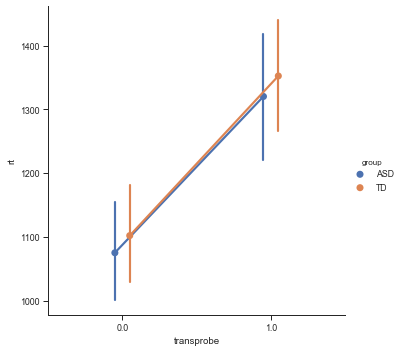

In [44]:
dfDL = df[((df.transprobe==0) | (df.transprobe==1)) & (df.correct==1) & (df.previous_correct == 1)]
print(dfDL.groupby(['group','transprobe']).rt.count())
sns.catplot(x="transprobe", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ transprobe * group", groups="subjectId",data=dfDL, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

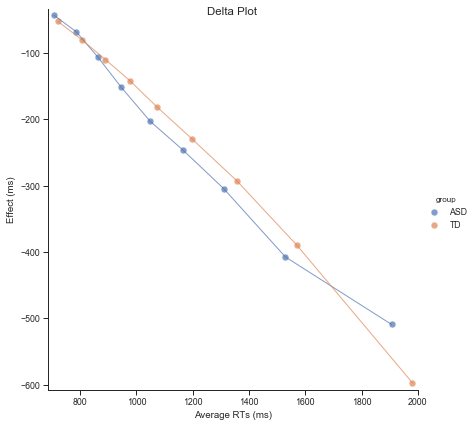

In [477]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "transprobe", [0,1])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "transprobe", [0,1])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')

# Learning within probe trials?

Note that only part of the sequences have 2 probe trials.

group  trialN
ASD    0         2505
       1         1382
TD     0         2530
       1         1313
Name: rt, dtype: int64
                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                 7730
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                  94
                      Estimating Equations   Max. cluster size:                 191
Family:                           Gaussian   Mean cluster size:               157.8
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                      do, 12 sep 2019   Scale:                      258367.261
Covariance type:                    robust   Time:                         17:09:51
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

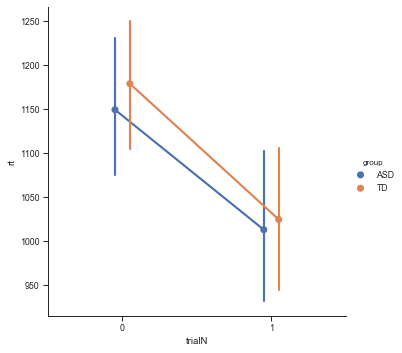

In [481]:
dfDL = df[((df.trialN==0) | (df.trialN==1)) & (df.dsd==5) & (df.correct==1) & (df.previous_correct == 1)]
print(dfDL.groupby(['group','trialN']).rt.count())
sns.catplot(x="trialN", y="rt", hue="group", units='subjectId', kind="point",dodge=.1, data=dfDL);

ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ trialN * group", groups="subjectId",data=dfDL, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

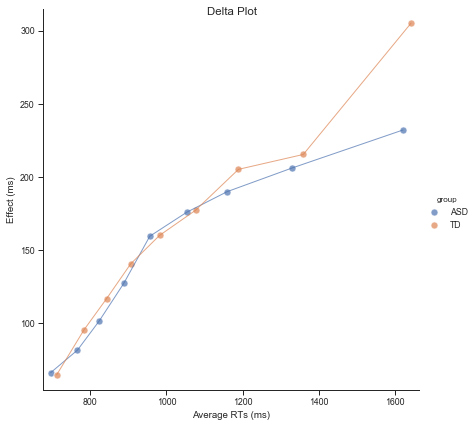

In [483]:
# Calculate delta plot data and plot it
d_dataASD = calc_delta_data(dfDL[(dfDL.group == 'ASD')], "subjectId", "rt", "trialN", [0,1])
d_dataASD['group']='ASD'
d_dataTD = calc_delta_data(dfDL[(dfDL.group == 'TD')], "subjectId", "rt", "trialN", [0,1])
d_dataTD['group']='TD'
d_data = pd.concat([d_dataASD, d_dataTD])

delta_plot(d_data, group='group')

# Inter-trial priming by target orientation within prime streaks

During each prime streak, the distribution from which the distractors were sampled remained the same. However, target orientation switched randomly within each prime streak. Therefore, we can assess inter-trial priming by the previous target orientation by analyzing reaction times on a trial as a function of the difference between the current target orientation and the previous target orientation (CT-PT).

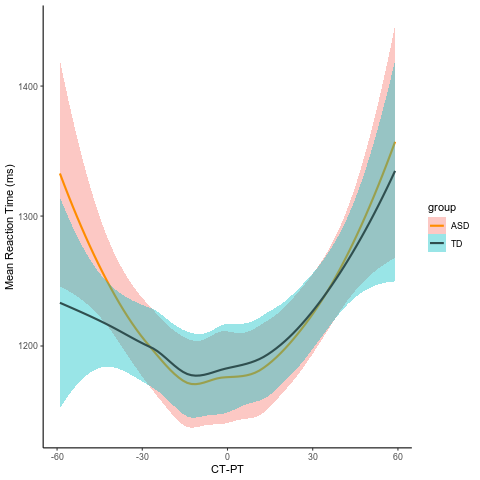

In [171]:
%%R

df_rt_ctpt_prime<- df_filter %>%
  filter(correct==1) %>%
  filter(dsd==10)%>%
  filter(trialN > 0) #not the first trial

df_rt_ctpt_prime %>%
  group_by(subjectId,group,ctpt) %>% #Rt for each ctpt per participant
  summarise(rt=mean(rt)) %>%
  ggplot(aes(ctpt,rt, color=group))  +geom_smooth(method='loess', aes(fill=group)) + theme_classic()+ scale_color_manual(values=c("darkorange", "darkslategrey"))+ xlab("CT-PT") + ylab("Mean Reaction Time (ms)") 
    

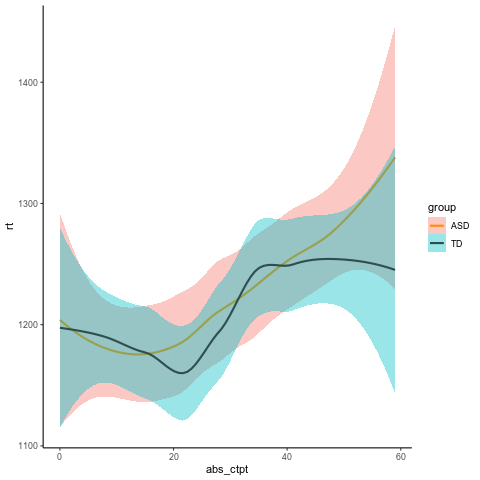

In [138]:
%%R

# Absolute ctpt:
df_rt_ctpt_prime %>%
  group_by(subjectId,group,abs_ctpt) %>%
  summarise(rt=mean(rt)) %>%
  ggplot(aes(abs_ctpt,rt, color=group)) + geom_smooth(method='loess', aes(fill=group))  + theme_classic()+ scale_color_manual(values=c("darkorange", "darkslategrey"))

In [ ]:
%%R

#Absolute difference between current target and previous target as predictor
lmer_rt_ctpt1 <- lmer(log_rt~ abs_ctpt_z*group + (abs_ctpt_z|subjectId), data=df_rt_ctpt_prime)
summary(lmer_rt_ctpt1)

#Difference between current target and previous target as quadratic predictor  
lmer_rt_ctpt2 <- lmer(log_rt~ ctpt_z2*group + (ctpt_z2|subjectId), data=df_rt_ctpt_prime)
summary(lmer_rt_ctpt2)

#Bayesian Analysis
bf_rt <- generalTestBF(log_rt ~ ctpt_z2 * group + subjectId, data = as.data.frame(df_rt_ctpt_prime), 
                    whichRandom = "subjectId", neverExclude = "subjectId")
bf_df_rt <- as.data.frame(bf_rt)
bf_sorted_rt <- sort(bf_rt/ max(bf_rt))
bf_sorted_df_rt <- as.data.frame(bf_sorted_rt)
bf_sorted_df_rt$bfs <- (1/bf_sorted_df_rt$bf)
print(bf_sorted_df_rt)

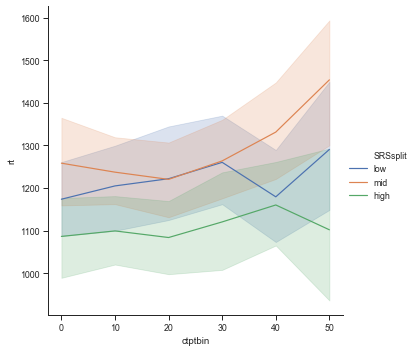

In [45]:
df['ctptbin']=pd.cut(df.abs_ctpt.dropna(), bins=9, labels=range(0,90,10))
dfsumctpt = df.query("correct==1 & dsd==10 & trialN > 0").groupby(['subjectId', 'SRSsplit', 'ctptbin']).rt.mean().reset_index()

dfsumctpt.head(20)
g = sns.relplot(x="ctptbin", y="rt", hue="SRSsplit", kind="line", data=dfsumctpt);

In [47]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ abs_ctpt_z * group", groups="subjectId",data=df.query("correct==1 & dsd==10 & trialN > 0"), family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                24327
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                 294
                      Estimating Equations   Max. cluster size:                 557
Family:                           Gaussian   Mean cluster size:               496.5
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Mon, 16 Sep 2019   Scale:                      417191.354
Covariance type:                    robust   Time:                         16:46:57
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1205.6828     41.307     29.189      0

# Role-reversal effect

In [417]:
%%R

##ACCOUNT FOR CIRCULARITY
data1<-filter(df_filter,ctpd< -60)
data1 <- data1 %>% mutate(ctpd = ctpd + 180)
data2<-filter(df_filter,ctpd> 60)
data2 <- data2 %>% mutate(ctpd = ctpd - 180)
df_filter_circ <-rbind(df_filter,data1,data2)

##ACCOUNT FOR CIRCULARITY
data1<-df_filter[df_filter$cdpd<-60,]
data1 <- data1 %>% mutate(cdpd = cdpd + 180)
data2<-df_filter[df_filter$cdpd>60,]
data2 <- data2 %>% mutate(cdpd = cdpd - 180)
df_filter_circ_cdpd <-rbind(df_filter,data1,data2)

R[write to console]: Warning:
R[write to console]:  Ignoring unknown aesthetics: show.legend



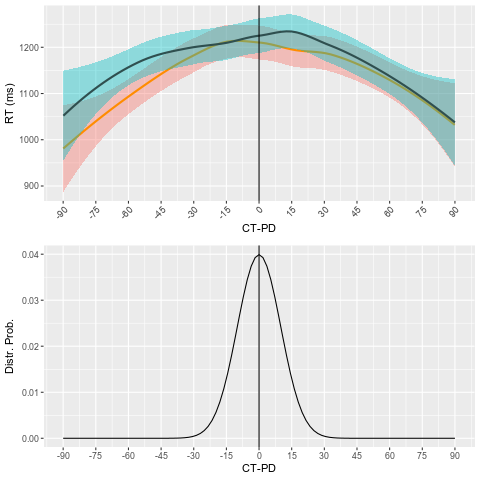

In [424]:
%%R

# rt ~ ct-pd plot
ctpd_plot <-df_filter_circ%>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) %>%#Only first trial of test streak 
  ggplot(aes(x=ctpd,y=rt, color=group,show.legend = FALSE)) + geom_smooth(method = "loess", aes(fill = group,show.legend = FALSE)) +  xlab("CT-PD") + ylab("RT (ms)")  + scale_x_continuous(breaks = seq(-90,90, by=15), limits=c(-90,90))   + scale_color_manual(values=c("darkorange", "darkslategrey")) + geom_vline(xintercept = 0) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

#Plot of distribution of distractors
distribution_plot <- ggplot(data = data.frame(x = c(-90, 90)), aes(x)) +
  stat_function(fun = dnorm, n = 101, args = list(mean = 0, sd = 10))  + scale_x_continuous(breaks = seq(-90,90, by=15), limits=c(-90,90))+  xlab("CT-PD")+ geom_vline(xintercept = 0)+ ylab("Distr. Prob.")

# rt ~ absolute ct-pd plot
abs_ctpd_plot <-df_filter_circ %>%
  mutate(abs_ctpd = abs(ctpd)) %>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) %>% #Only first trial of test streak 
  ggplot(aes(x=abs_ctpd,y=rt,color=group)) + geom_smooth(method = "loess", aes(fill = group)) + scale_x_continuous(breaks = seq(0,90, by=15), limits=c(0,90)) + xlab("absolute CT-PD") + ylab("Mean Raction Time (ms)")   + scale_color_manual(values=c("darkorange", "darkslategrey"))

#Plot of half distribution of distractors
half_distribution_plot <- ggplot(data = data.frame(x = c(-90, 90)), aes(x)) +
  stat_function(fun = dnorm, n = 101, args = list(mean = 0, sd = 10))  + scale_x_continuous(breaks = seq(-90,90, by=15), limits=c(0,90))+  xlab("CT-PD")+ ylab("Distr. Prob.")

plot_grid(ctpd_plot + theme(legend.position="none"), distribution_plot,ncol=1,align = 'v')

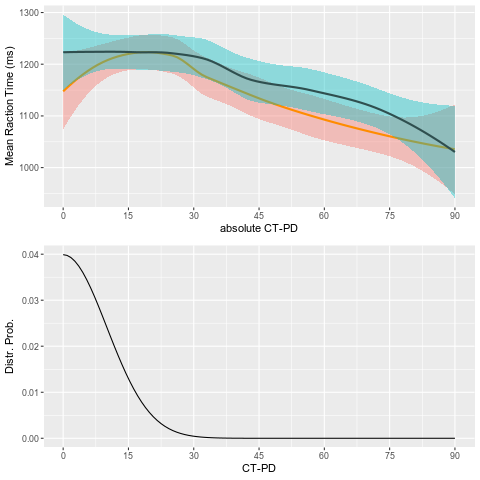

In [425]:
%%R

plot_grid(abs_ctpd_plot + theme(legend.position="none"), half_distribution_plot,ncol=1,align = 'v')

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



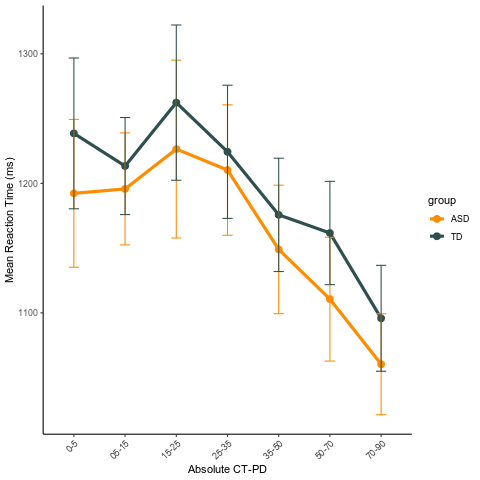

In [429]:
%%R

df_steps<-df_filter %>%
  mutate(abs_ctpd = abs(ctpd)) %>%
  filter(correct==1) %>% #only RTs for correct responses
  filter(previous_correct ==1) %>% #Only after a correct trial
  filter(dsd==5) %>% #For test streaks with Gaussian distr
  filter(trialN == 0) #%>% #Only first trial of test streak 
  #group_by(subjectId,group,abs_ctpd) %>%
  #summarise(rt=mean(rt), log_rt=mean(log_rt), totBlockN=totBlockN)


df_steps$step_ctpd[df_steps$abs_ctpd< 5] <- "0-5"
df_steps$step_ctpd[df_steps$abs_ctpd> 4 & df_steps$abs_ctpd< 15] <- "05-15"
df_steps$step_ctpd[df_steps$abs_ctpd> 14 & df_steps$abs_ctpd< 25] <- "15-25"
df_steps$step_ctpd[df_steps$abs_ctpd> 24 & df_steps$abs_ctpd< 35] <- "25-35"
df_steps$step_ctpd[df_steps$abs_ctpd> 34 & df_steps$abs_ctpd< 50] <- "35-50"
df_steps$step_ctpd[df_steps$abs_ctpd> 49 & df_steps$abs_ctpd< 70] <- "50-70"
df_steps$step_ctpd[df_steps$abs_ctpd> 69 ] <- "70-90"


df_steps$step_ctpd = as.factor(df_steps$step_ctpd)

df_steps_plot <- df_steps%>%
  group_by(subjectId,step_ctpd, group)%>%
  summarise(rt = mean(rt))%>%
  ggplot(aes(x=step_ctpd,y=rt, color = group)) + stat_summary(fun.y=base::mean, geom="point", size =3) + stat_summary(fun.y=base::mean, geom="line")+ stat_summary(fun.y=base::mean, geom="line",size=1.5, aes(group = group))+ stat_summary(fun.data = "mean_se", geom="errorbar", width = 0.2)  + theme_classic() + xlab("Absolute CT-PD") + ylab("Mean Reaction Time (ms)")  + scale_color_manual(values=c("darkorange", "darkslategrey")) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

df_steps_plot




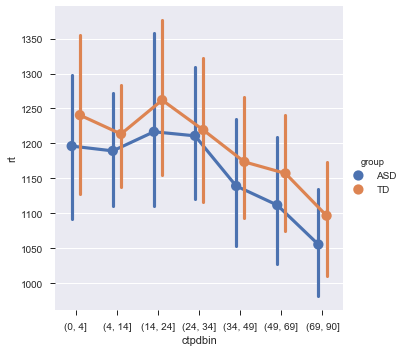

In [91]:
dfsteps = df.query("previous_correct==1 & correct==1 & dsd==5 & trialN == 0")
bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 14), (14, 24),(24,34),(34,49),(49,69), (69,90)])
dfsteps['ctpdbin'] = pd.cut(dfsteps.abs_ctpd, bins, labels=False) #["0-5","5-15", "15-25","25-35","35-50","50-70","70-90"]
dfsteps.ctpdbin = dfsteps.ctpdbin.astype('category')

dfstepssum = dfsteps.groupby(['group','subjectId', 'ctpdbin']).mean().reset_index()

g = sns.catplot(x="ctpdbin", y="rt", hue="group", kind="point", data=dfstepssum, dodge=.2);

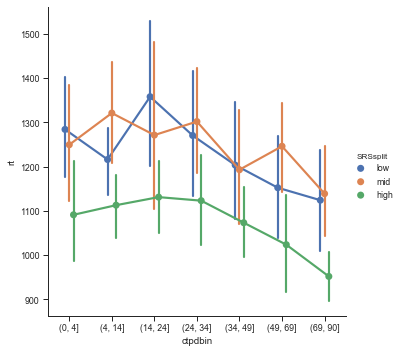

In [632]:
dfsteps = df.query("previous_correct==1 & correct==1 & dsd==5 & trialN == 0")
bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 14), (14, 24),(24,34),(34,49),(49,69), (69,90)])
dfsteps['ctpdbin'] = pd.cut(dfsteps.abs_ctpd, bins, labels=False) #["0-5","5-15", "15-25","25-35","35-50","50-70","70-90"]
dfsteps.ctpdbin = dfsteps.ctpdbin.astype('category')

dfstepssum = dfsteps.groupby(['SRSsplit','subjectId', 'ctpdbin']).mean().reset_index()

g = sns.catplot(x="ctpdbin", y="rt", hue="SRSsplit", kind="point", data=dfstepssum, dodge=.2);

In [428]:
%%R

lmer_RT_step<-df_steps%>%
  lmer(log_rt ~ step_ctpd * group + (step_ctpd|subjectId),REML=T, data= .)
summary(lmer_RT_step)

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_rt ~ step_ctpd * group + (step_ctpd | subjectId)
   Data: .

REML criterion at convergence: 4080.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.0957 -0.6889 -0.1288  0.5645  4.1082 

Random effects:
 Groups    Name           Variance Std.Dev. Corr                               
 subjectId (Intercept)    0.030731 0.17530                                     
           step_ctpd05-15 0.006833 0.08266  -0.69                              
           step_ctpd15-25 0.007010 0.08372  -0.07  0.72                        
           step_ctpd25-35 0.003554 0.05961  -0.13  0.78  0.90                  
           step_ctpd35-50 0.008512 0.09226  -0.43  0.94  0.89  0.94            
           step_ctpd50-70 0.008657 0.09304  -0.41  0.71  0.42  0.76  0.72      
           step_ctpd70-90 0.010052 0.10026  -0.47  0.76  0.43  0.75  0.74  0.99
 Residual                 0.122809 0.35044 

R[write to console]: 
Correlation matrix not shown by default, as p = 14 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




convergence code: 0
boundary (singular) fit: see ?isSingular



In [633]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ C(ctpdbin) * SRSsplit", groups="subjectId",data=dfstepssum, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                  287
Model:                                 GEE   No. clusters:                       41
Method:                        Generalized   Min. cluster size:                   7
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 7.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                      do, 12 sep 2019   Scale:                       53717.388
Covariance type:                    robust   Time:                         20:24:04
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------

## Difference in RTs between test trials where target orientation lies within vs out of the range of the previous distractor distribution

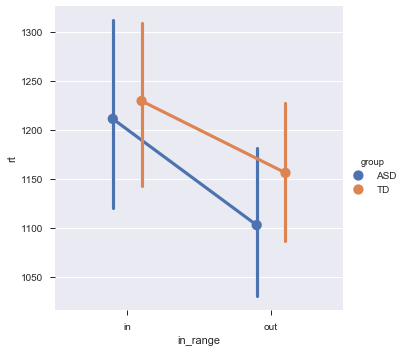

In [93]:
dfrange = df.query("previous_correct==1 & correct==1 & dsd==5 & trialN == 0")

dfrange['in_range'] = np.where(dfrange.abs_ctpd > 30, "out", "in")

dfrangesum = dfrange.groupby(['group','subjectId', 'in_range']).mean().reset_index()


g = sns.catplot(x="in_range", y="rt", hue="group", units='subjectId', kind="point", data=dfrangesum, dodge=.2);



In [94]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("rt ~ in_range * group", groups="subjectId",data=dfrangesum, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                          rt   No. Observations:                   98
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                   2
                      Estimating Equations   Max. cluster size:                   2
Family:                           Gaussian   Mean cluster size:                 2.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Wed, 18 Sep 2019   Scale:                       44617.539
Covariance type:                    robust   Time:                         15:15:18
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1211.4739     48.968   

## Does in range effect vary with SP, SRS, IU?

Yes, no, no
But note few datapoints for SP (missing data)

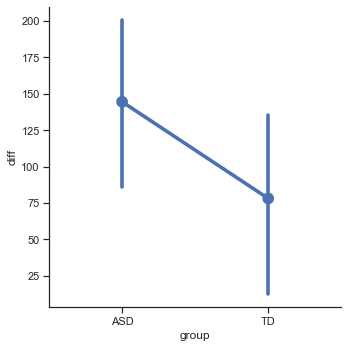

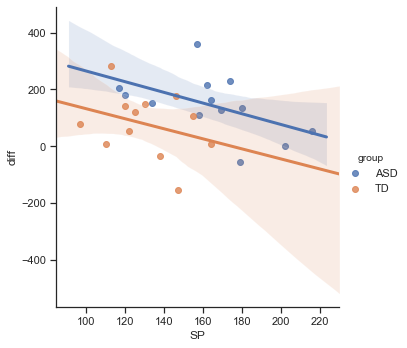

In [284]:
rangediff = dfrangesum.pivot_table(index=['group','subjectId','SP'],columns='in_range',values='rt').reset_index()

rangediff['diff']= rangediff['in'] - rangediff['out']



g = sns.catplot(x="group", y="diff", units='subjectId', kind="point", data=rangediff, dodge=.2);


sns.lmplot(x="SP", y="diff", hue="group", data=rangediff);

In [281]:
ga = sm.families.Gaussian()
ex = sm.cov_struct.Exchangeable()

model1 = sm.GEE.from_formula("diff ~ SP * group", groups="subjectId",data=rangediff, family=ga, cov_struct=ex)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                        diff   No. Observations:                   25
Model:                                 GEE   No. clusters:                       25
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Gaussian   Mean cluster size:                 1.0
Dependence structure:         Exchangeable   Num. iterations:                     1
Date:                      ma, 09 sep 2019   Scale:                       10829.635
Covariance type:                    robust   Time:                         20:06:26
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        454.0353     83.582      5.432      0.000     290.217     617

**But only about half of participants took the SP:**

In [299]:
dfsumQ.groupby(['group']).SP.count()

group
ASD    13
TD     12
Name: SP, dtype: int64